In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_colwidth', 200)

In [2]:
# Import Data From Preliminary Analysis
df_hist = pd.read_pickle('calculations\df_hist.pickle')
df_spec = pd.read_pickle('calculations\df_spec.pickle')
df_arch = pd.read_pickle('calculations\df_arch.pickle')
df_summary = pd.read_pickle('calculations\df_summary.pickle')

# PLOTS AND RECOMMENDATIONS
using bins as utilised by specimen table

In [3]:
def plot_fork_length_by_sample(df_specimen, df_historical, sample_id, feature='fork_length', bin_width=5, density=False, subtitle='', duplicate='unknown', right=True):
    """ 
    duplicate can be True, False, or 'unknown' 
    right=True denotes right inclusive bins (the correct choice for this dataset as shown in prelim summary workbook)
        this is a hack because matplotlib doesn't have a parameter for this so bins are just offset by 0.1
    """
    
    figsize=(16,4)
    offset = 0.1 if right else 0  # this is a hack - plt.hist() doesn't seem to have a right inclusive option for bins...
    bins_plot = [x*5+offset + 20 for x in range(30)]  # centered on n%5==3 like df_spec, rounded to int%5 (could use +20.5 also to center perfectly on n%5==3)
    
    if duplicate == 'unknown':
        colours = sns.color_palette()[0], sns.color_palette('pastel')[1]
    elif duplicate: # duplicated
        colours = sns.color_palette()[0], sns.color_palette('pastel')[2]
    else: # not duplicated
        colours = sns.color_palette()[0], sns.color_palette('deep')[6]
        
    plt.figure(figsize=figsize)
    plt.xlim(20, 170)  # use same scale for all histograms for easy comparison
    df_specimen.loc[df_specimen.sample_id==sample_id, feature].dropna().hist(alpha=0.6, color=colours[0], density=density, label=f'Specimen {feature}', bins=bins_plot)
    df_historical.loc[df_historical.sample_id==sample_id, feature].dropna().hist(alpha=0.8, color=colours[1], density=density, label=f'Bioligical {feature}', bins=bins_plot, rwidth=0.7)
    
    feature_title = feature.title().replace("_"," ")
    plt.legend(loc='upper right')
    subtitle = ' - ' + subtitle if subtitle else ''
    plt.title(f'Sample {sample_id}: {feature_title} Comparison - Specimen vs Biological Data{subtitle}')
    plt.ylabel('Counts')
    plt.xlabel(f'{feature_title}')
    plt.show()


# no specimen data == not double counted
### RECOMMENDATION: 
* classify as not duplicated

In [4]:
no_specimen_data = [x for x in df_hist.sample_id.unique() if x not in df_spec.sample_id.unique()]
df_summary.loc[df_summary.index.isin(no_specimen_data), 'specimen_data'] = False
no_specimen_data

[4390,
 4391,
 4392,
 4393,
 4394,
 4395,
 4396,
 4397,
 4398,
 4399,
 4400,
 4408,
 4599,
 5133,
 5319,
 7877,
 7880,
 7884]

# more bio data than spec data
(at least some bio samples aren't double counted)

### RECOMMENDATION:
* classify all as duplicated == False
* exceptions / possible duplicates?
    * none obvious
* confirm by inspecting plots

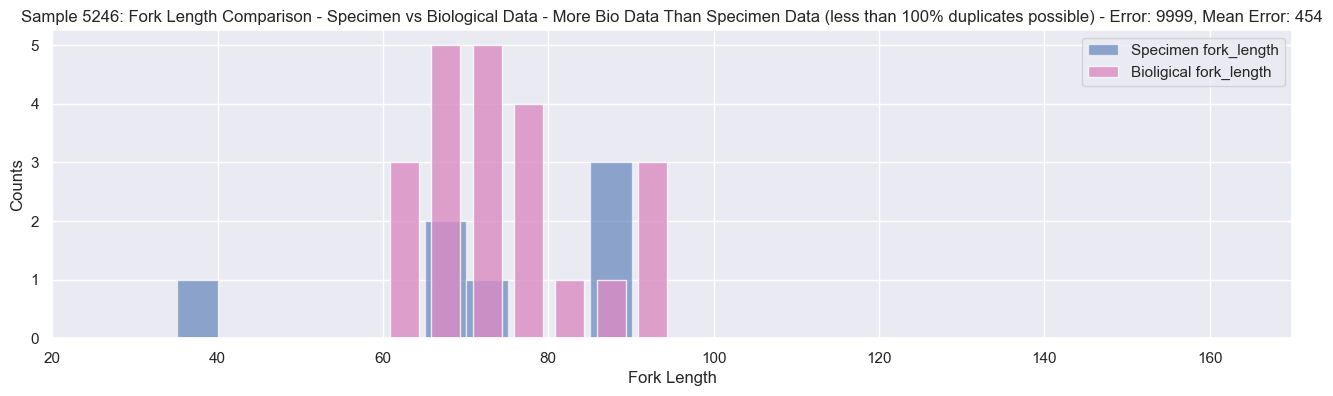

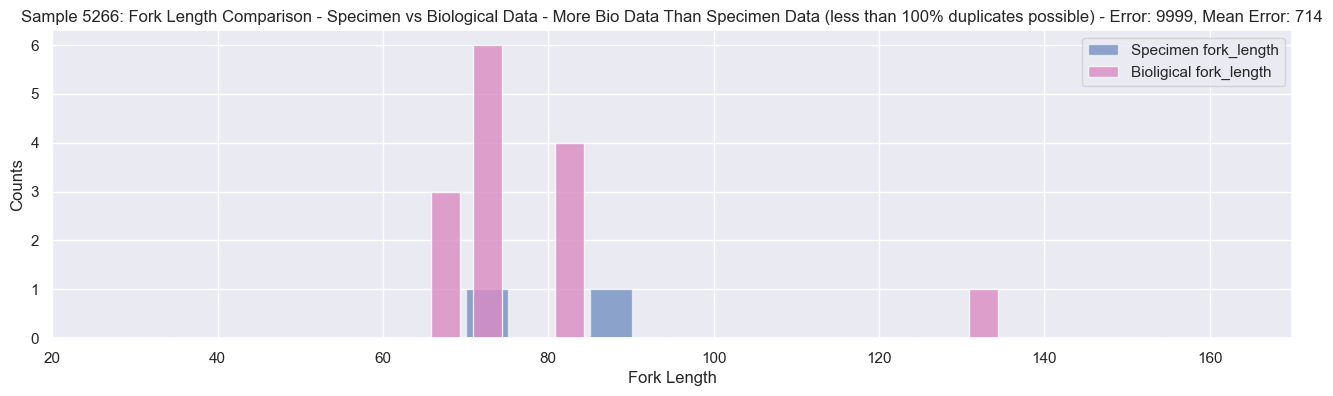

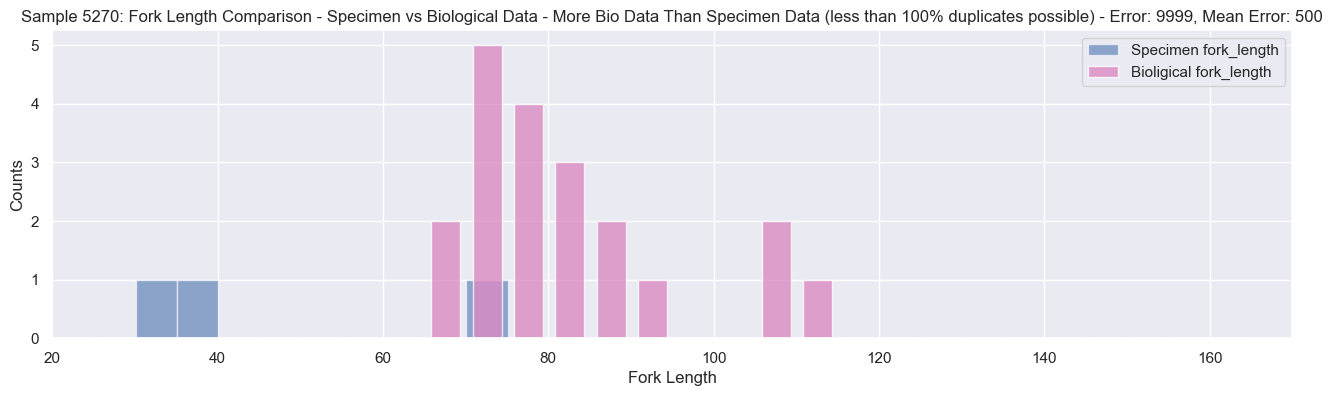

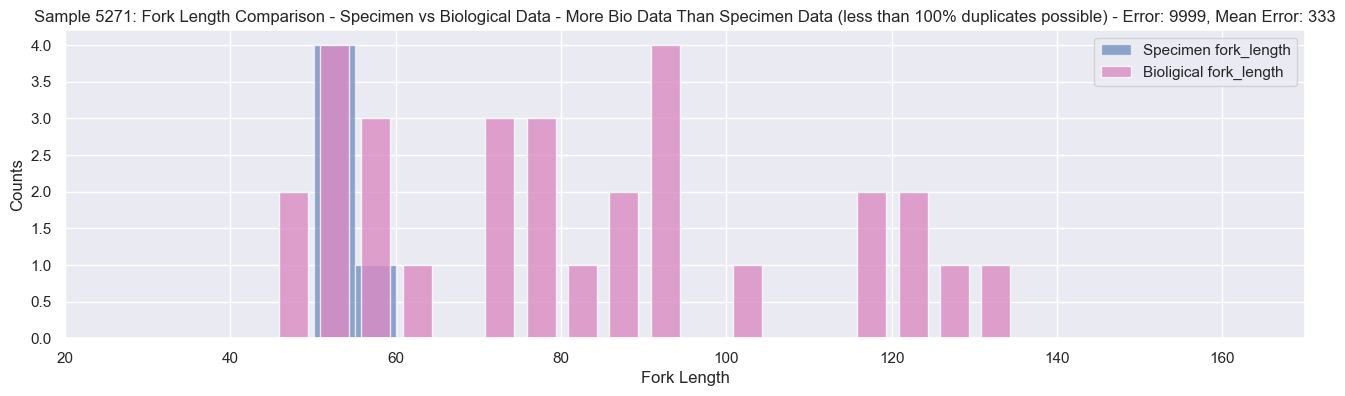

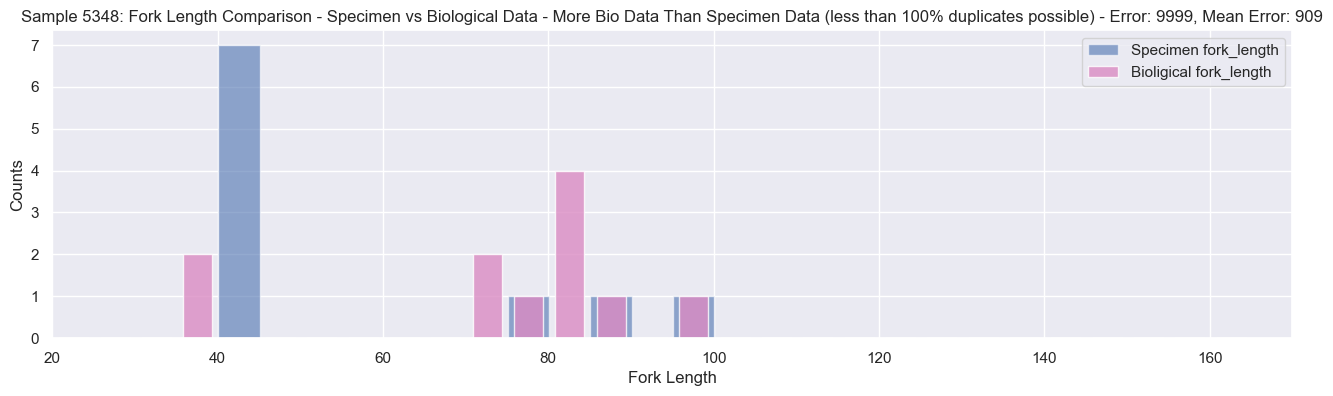

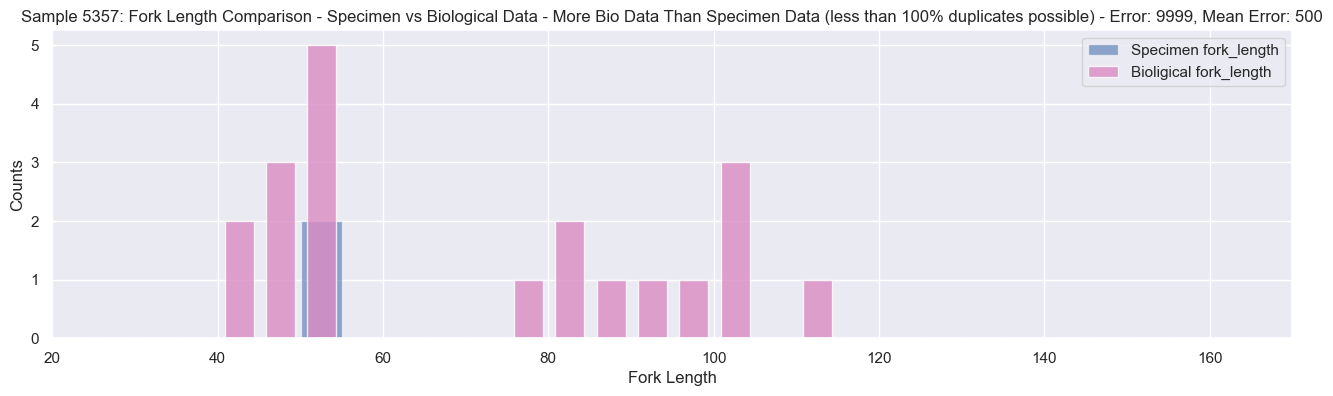

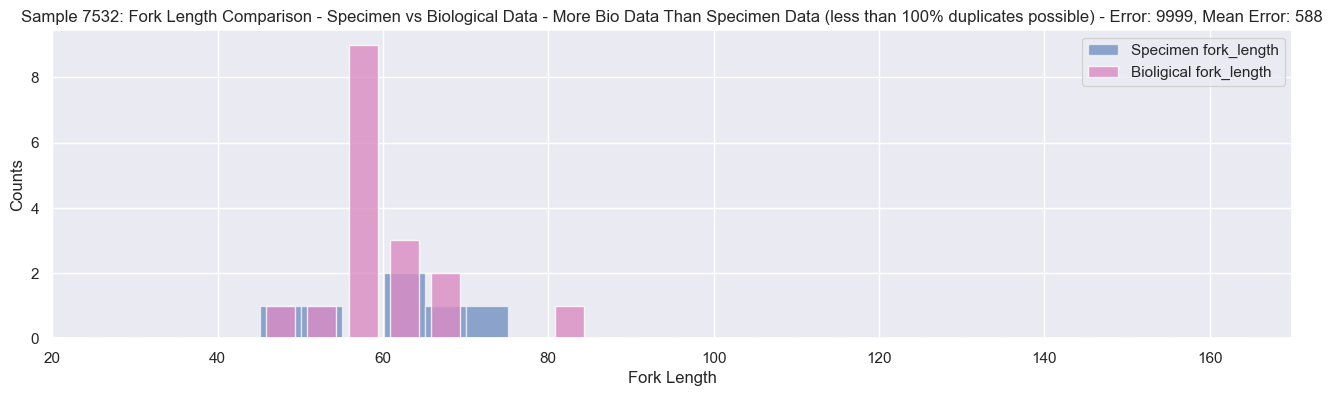

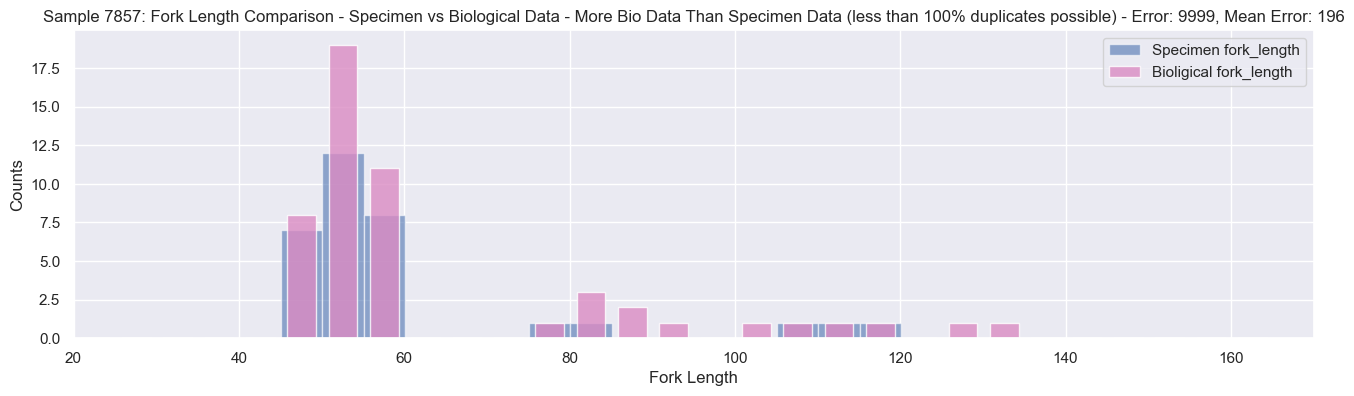

In [5]:
df_summary.loc[(df_summary.n_hist > df_summary.n_spec) & (df_summary.n_spec != 0), 'enough_spec_data'] = False
for i in df_summary[df_summary.enough_spec_data.notnull()].index:
    plot_fork_length_by_sample(df_spec, df_hist, i, subtitle=f'More Bio Data Than Specimen Data (less than 100% duplicates possible) - Error: {round(df_summary.loc[i].error)}, Mean Error: {round(df_summary.loc[i].mean_error)}', duplicate=False)

# zero error samples - all bins matched

### RECOMMENDATION: 
* classify all low error samples as duplicate == True

In [6]:
df_summary.loc[df_summary.error == 0, 'zero_error_sample'] = True
print(df_summary.zero_error_sample.notnull().sum(), 'Zero Error Samples')

534 Zero Error Samples


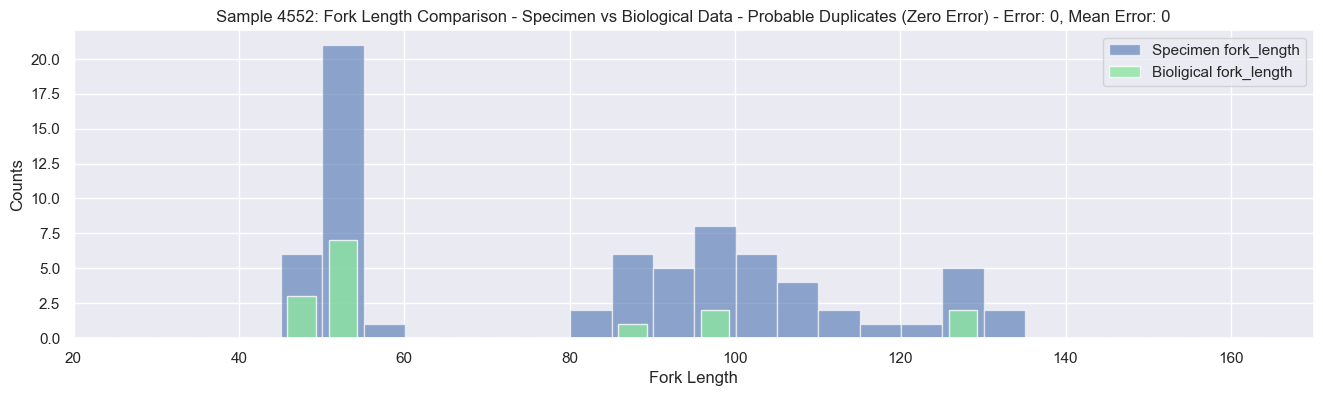

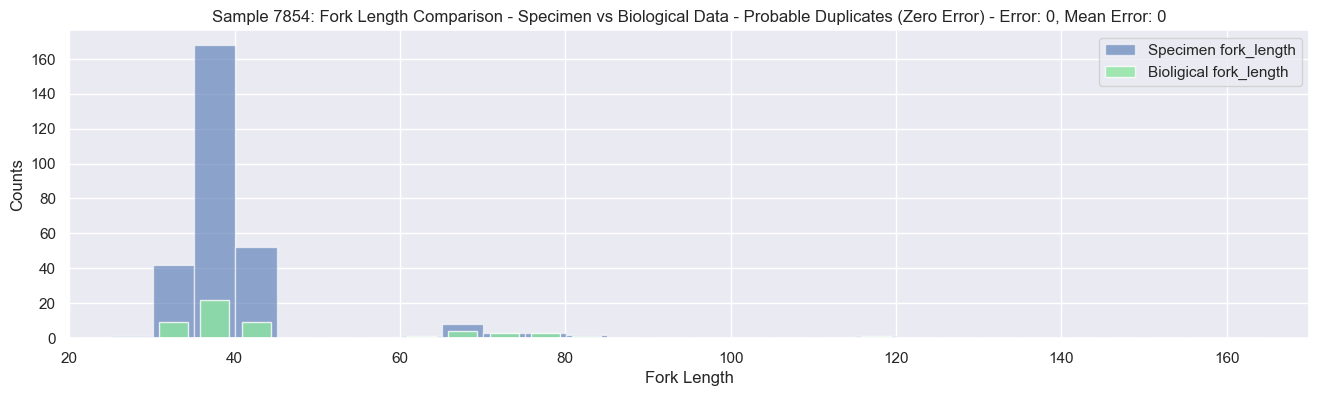

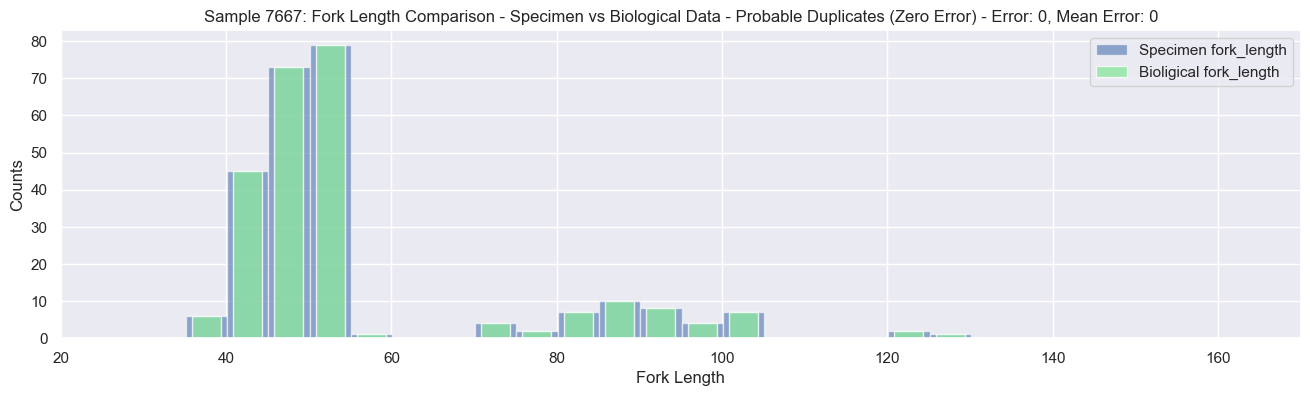

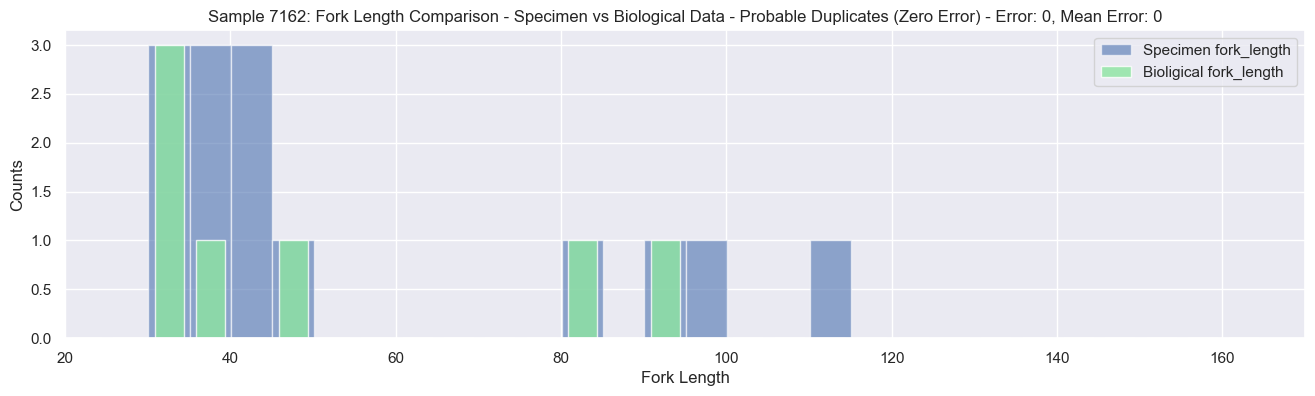

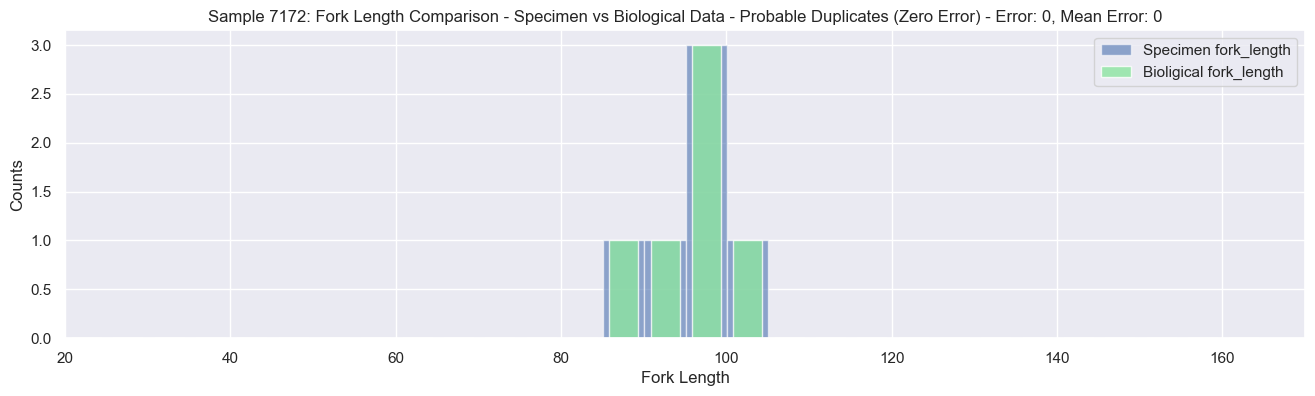

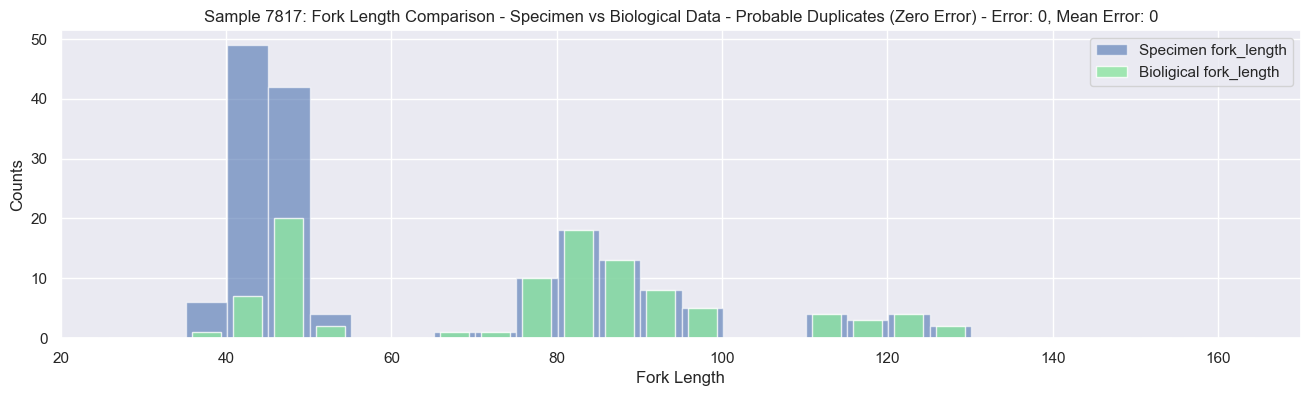

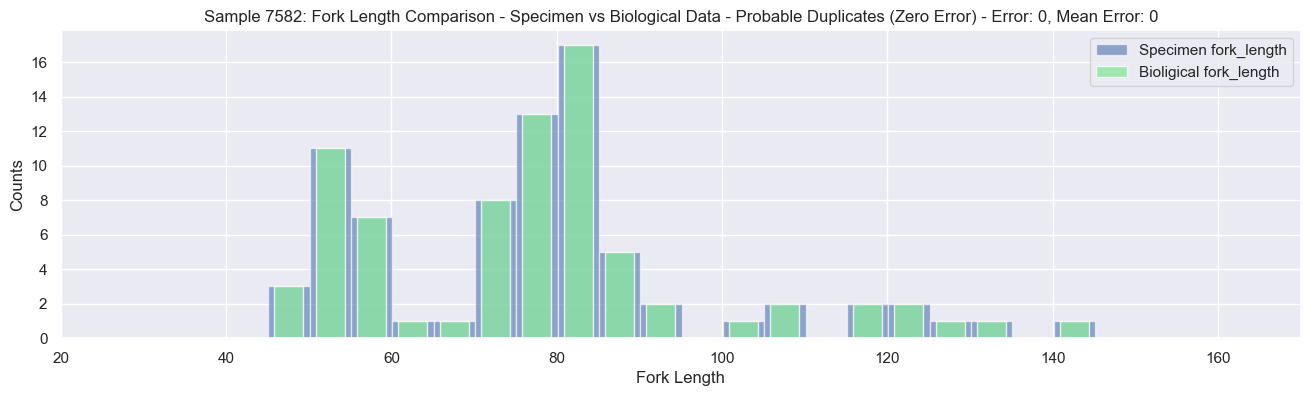

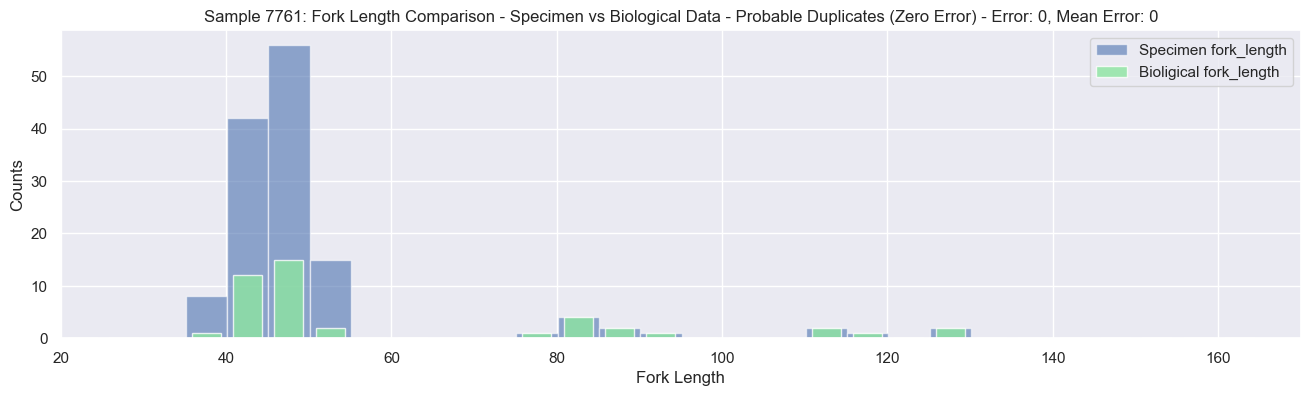

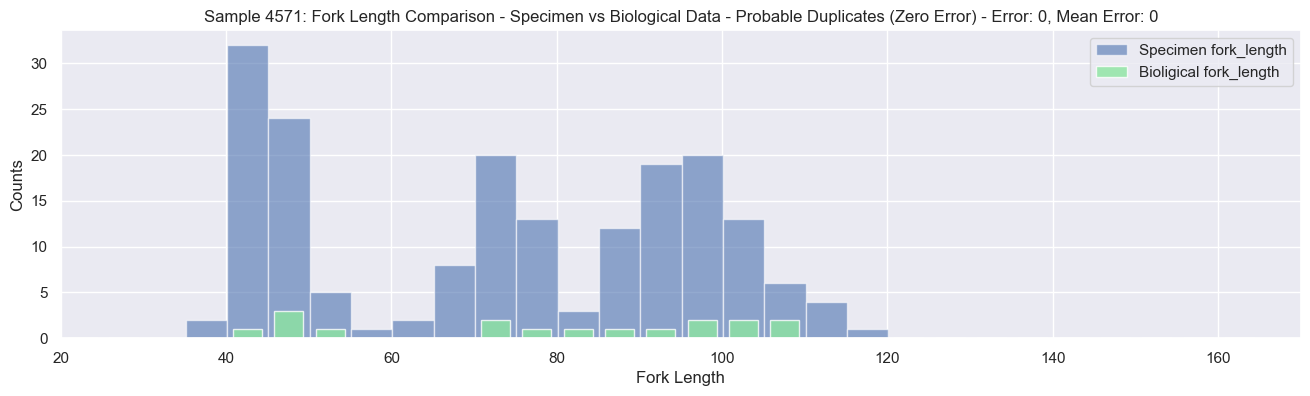

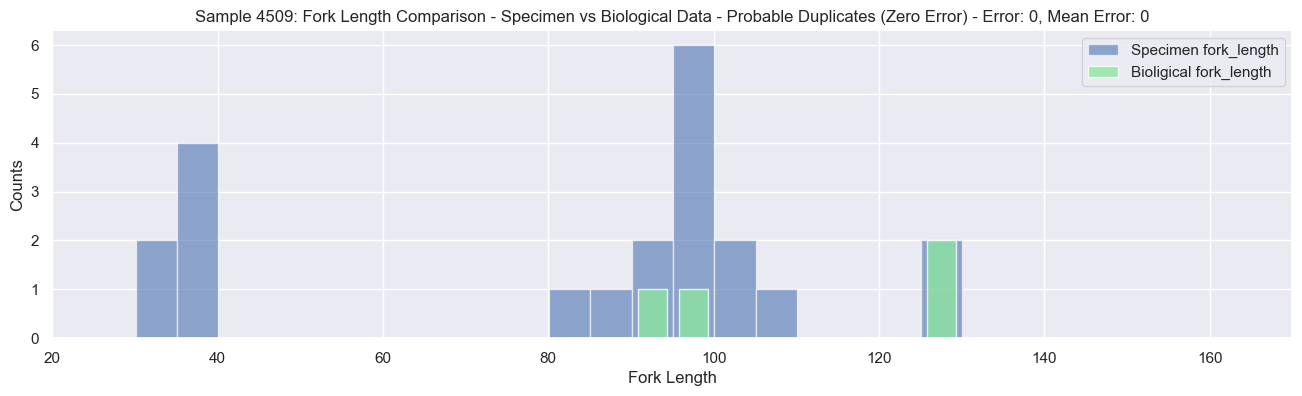

In [7]:
# just plot a sample
for i in df_summary[df_summary.zero_error_sample == True].sample(10).index:
    plot_fork_length_by_sample(df_spec, df_hist, i, subtitle=f'Probable Duplicates (Zero Error) - Error: {round(df_summary.loc[i].error)}, Mean Error: {round(df_summary.loc[i].mean_error)}', duplicate=True)

# high error samples sorted by least error first

### RECOMMENDATION:
* classify all as not duplicates, with the following exceptions:
    * potential duplicates:
        * listed below
* confirm more by inspection, on a case-by-case basis

In [8]:
# matched counts
matched_counts = list(df_summary[df_summary.n_spec == df_summary.n_hist].index)

In [9]:
# testing for ranges of errors
if False:
    testmin, testmax = 10, 20
    print('\nMEAN ERROR RANGE TEST: ', testmin, testmax)
    for i in df_summary[(df_summary.mean_error >= testmin) & (df_summary.mean_error < testmax)].sample(5).index:
        plot_fork_length_by_sample(df_spec, df_hist, i, subtitle=f'Total Error: {round(df_summary.loc[i].error)}, Mean Error: {round(df_summary.loc[i].mean_error)}', duplicate=False)

    testmin, testmax = 100, 150
    print('\nERROR RANGE TEST: ', testmin, testmax)
    for i in df_summary[(df_summary.error >= testmin) & (df_summary.error < testmax)].sample(5).index:
        plot_fork_length_by_sample(df_spec, df_hist, i, subtitle=f'Total Error: {round(df_summary.loc[i].error)}, Mean Error: {round(df_summary.loc[i].mean_error)}', duplicate=False)

In [10]:
high_error, high_mean_error = 100, 10
potential_duplicates = [5280]
exclusions = matched_counts + no_specimen_data + list(df_summary[df_summary.enough_spec_data.notnull()].index)

df_summary.loc[
    (df_summary.error >= high_error) & (~df_summary.index.isin(exclusions)), 
    'high_error_potential_duplicate'] = False
df_summary.loc[
    (df_summary.mean_error >= high_mean_error) & (~df_summary.index.isin(exclusions)), 
    'high_error_potential_duplicate'] = False
df_summary.loc[
    (df_summary.error >= high_error) & (~df_summary.index.isin(exclusions)) & df_summary.index.isin(potential_duplicates), 
    'high_error_potential_duplicate'] = True
df_summary.loc[
    (df_summary.mean_error >= high_mean_error) & (~df_summary.index.isin(exclusions)) & df_summary.index.isin(potential_duplicates), 
    'high_error_potential_duplicate'] = True

30 High Error Samples


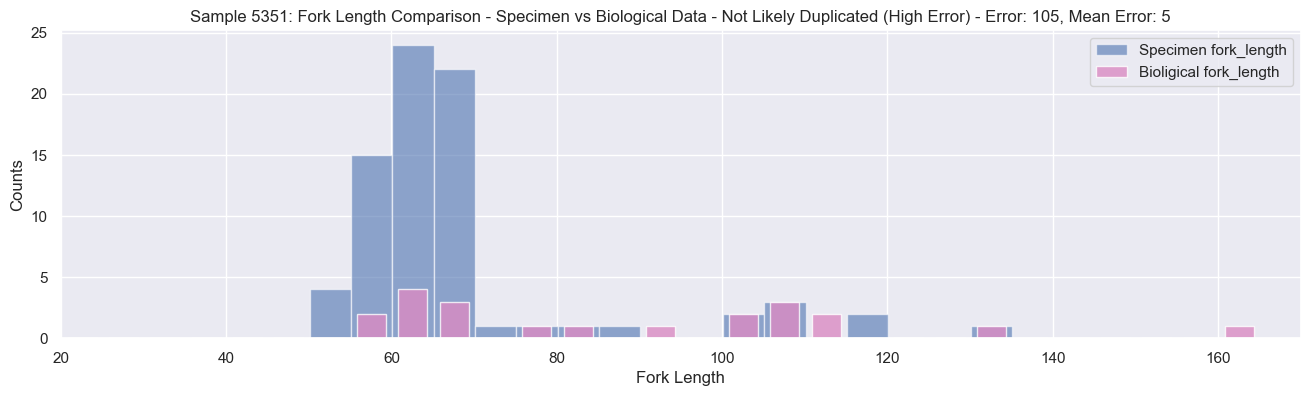

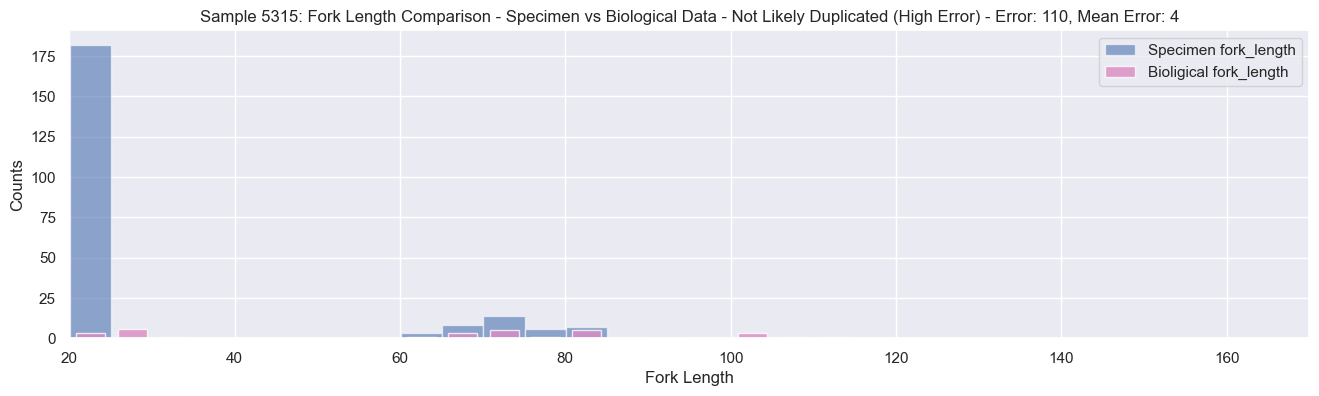




POTENTIAL DUPLICATE: Sample 5280


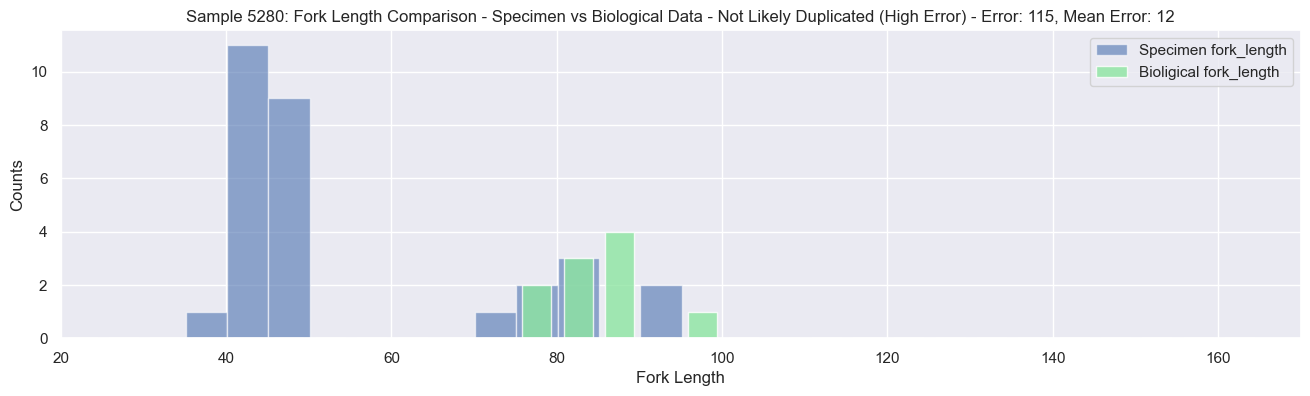

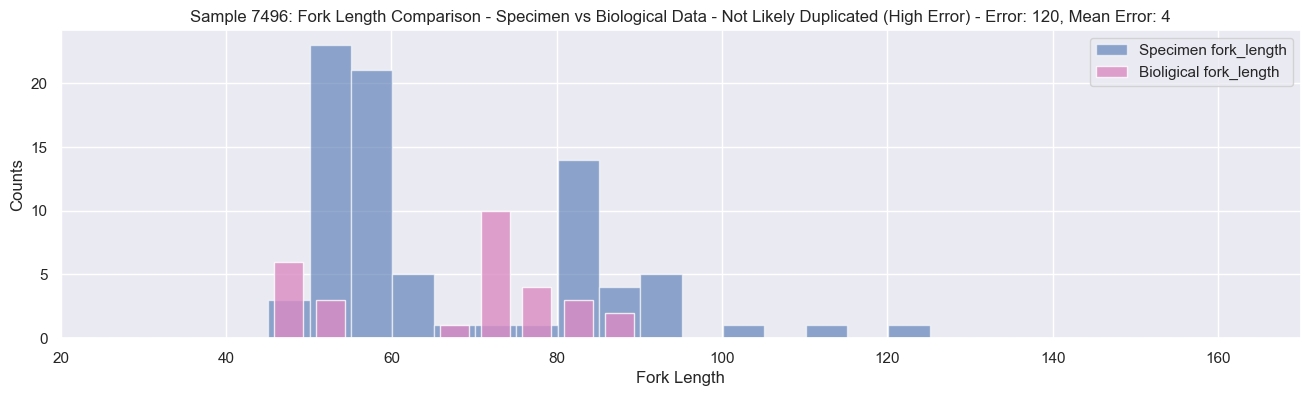

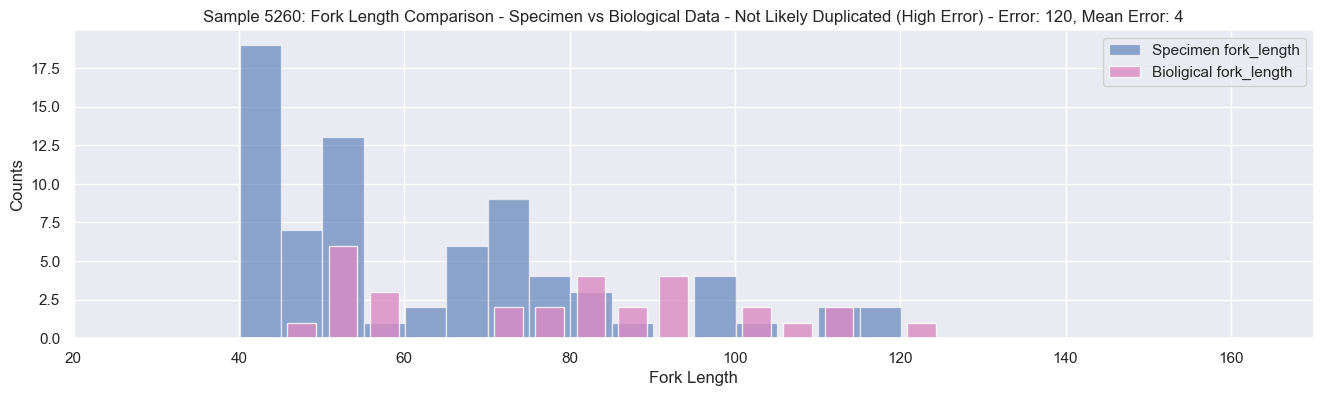

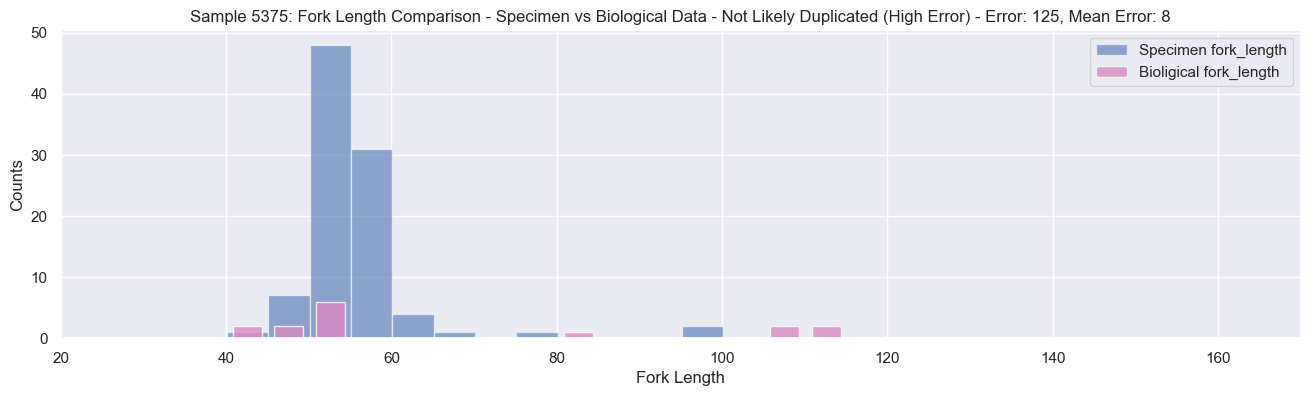

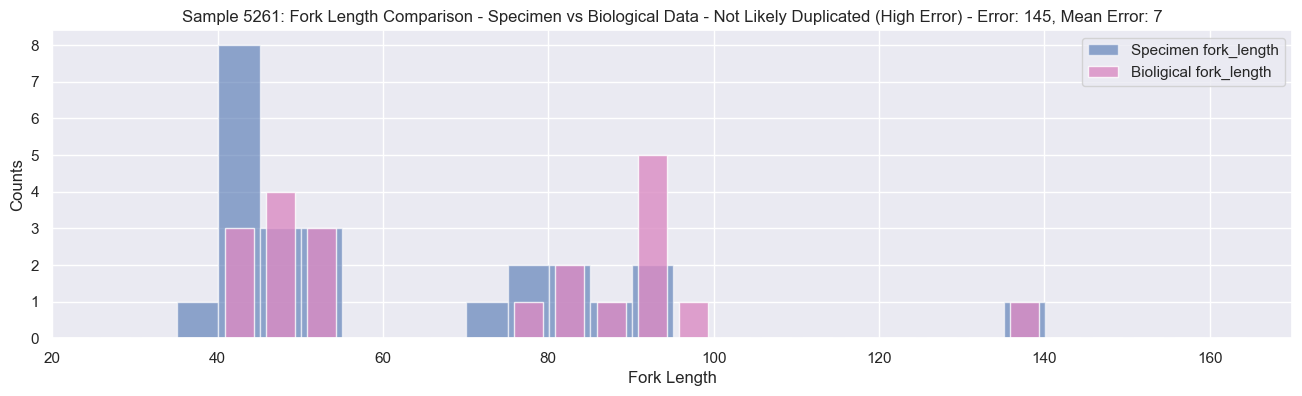

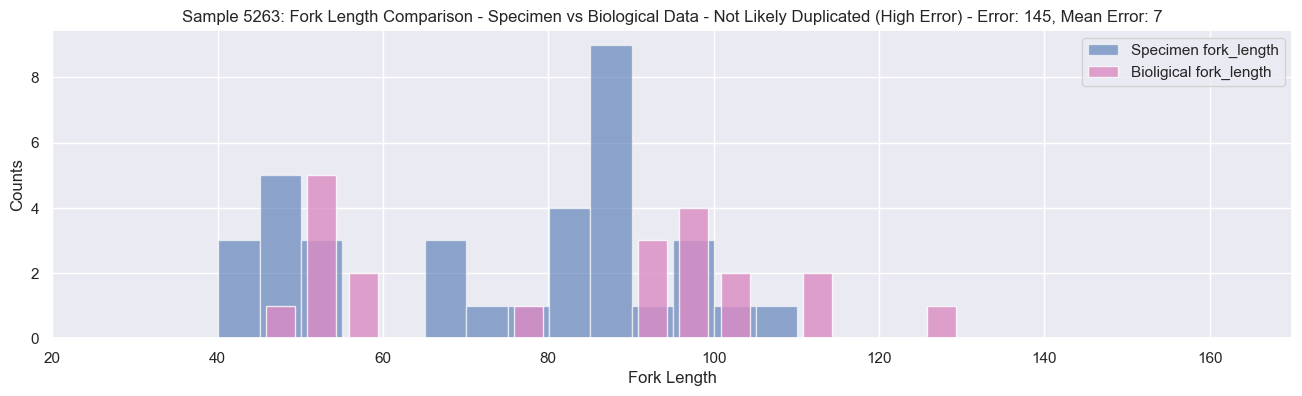

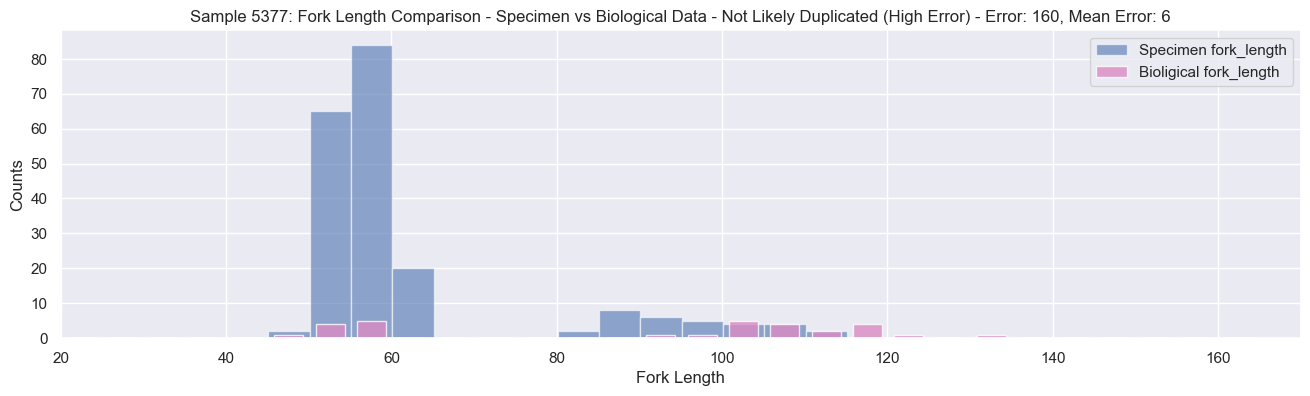

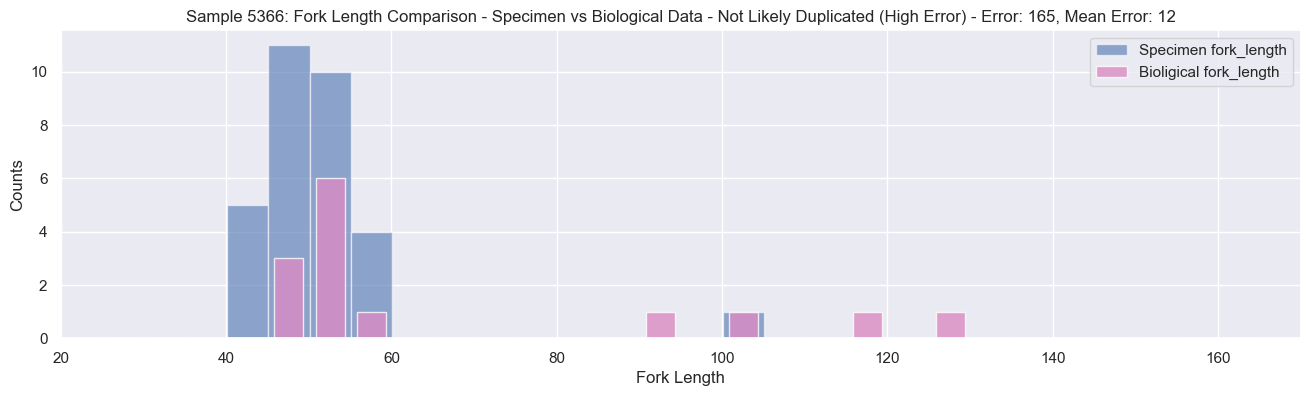

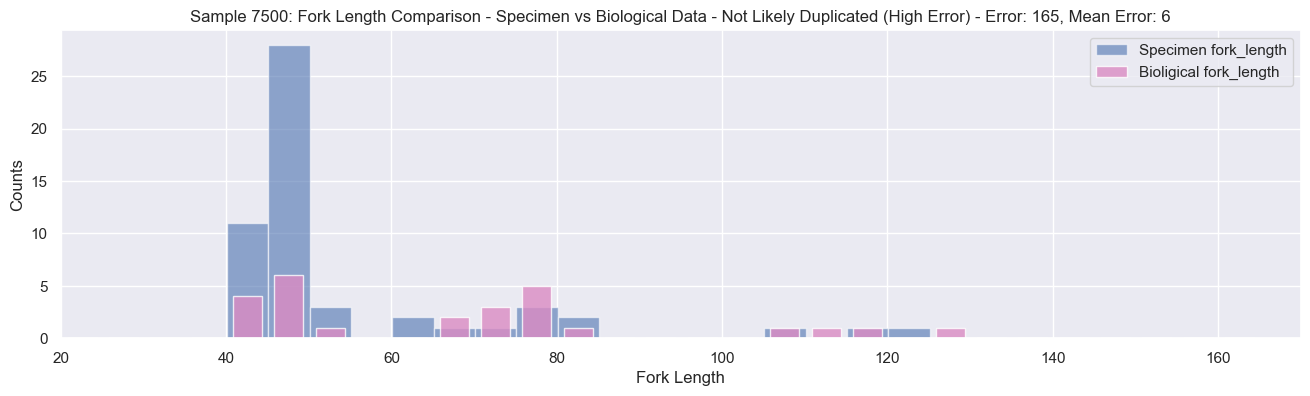

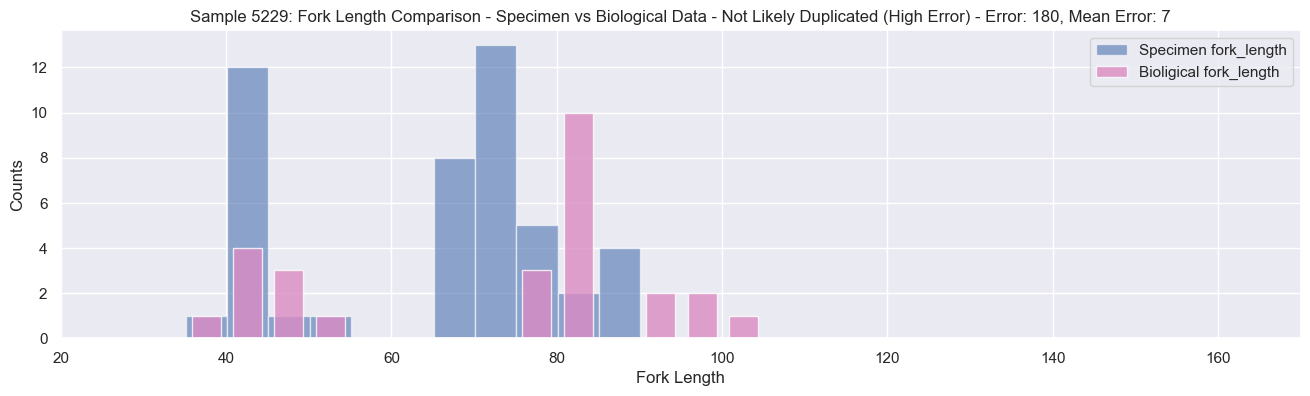

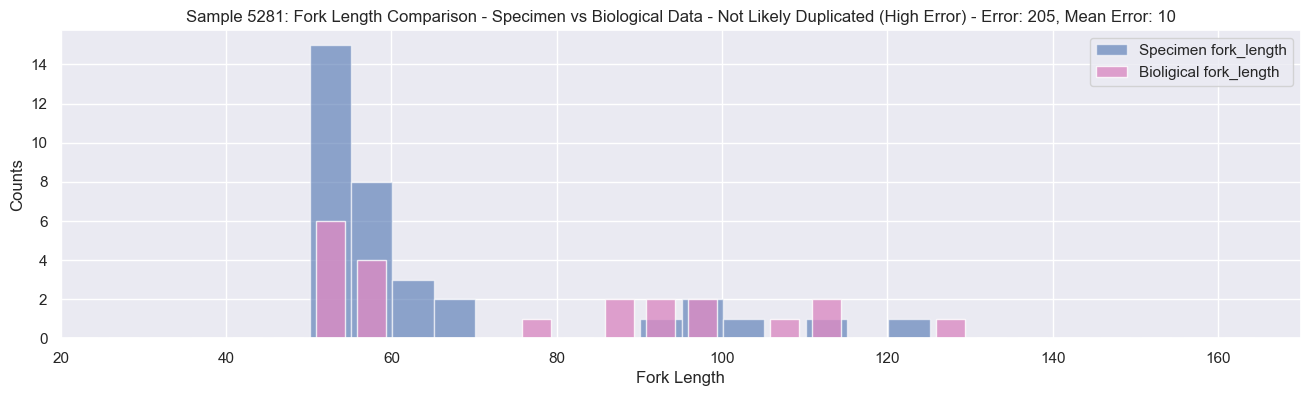

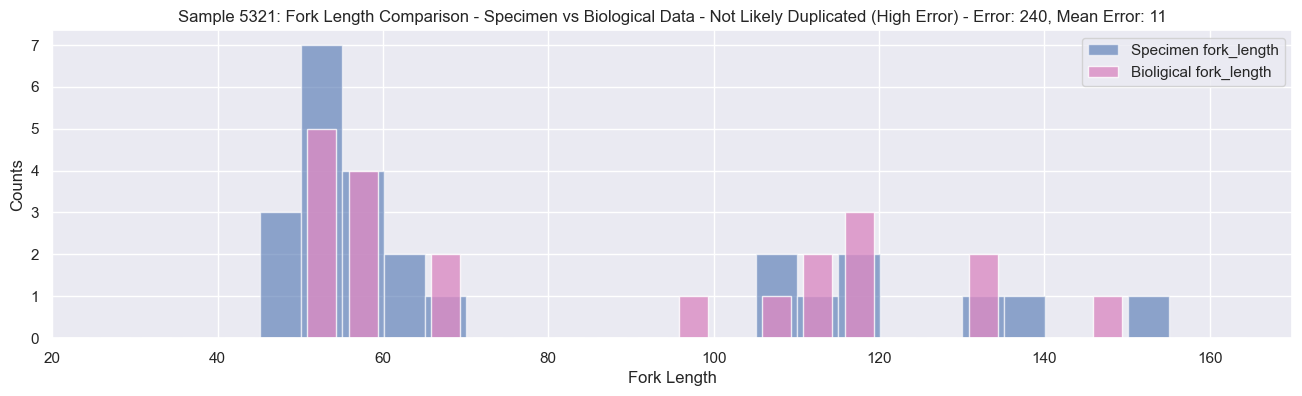

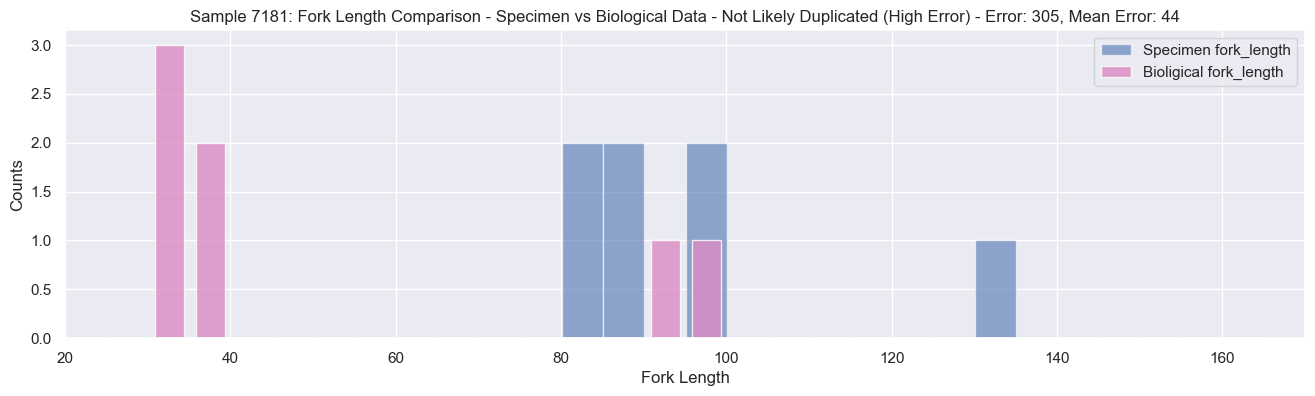

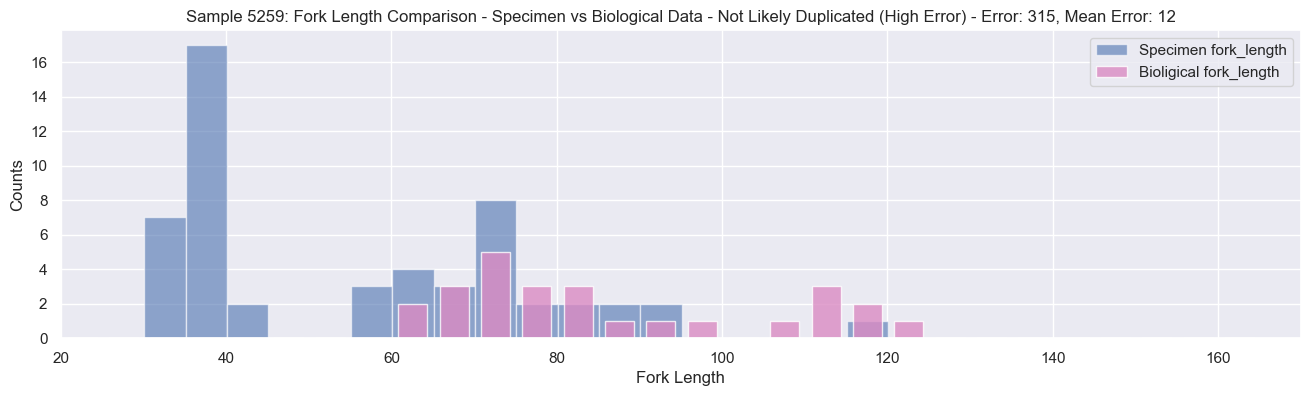

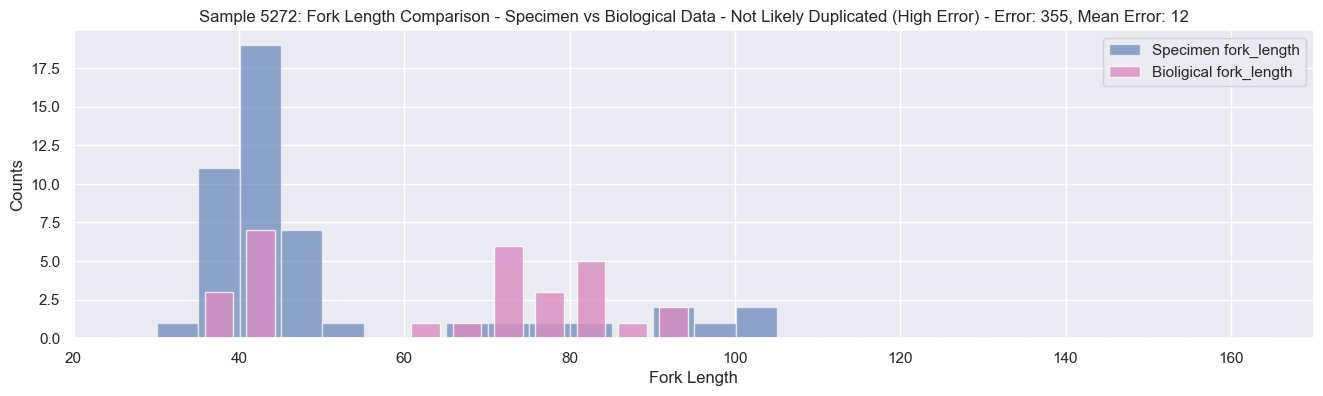

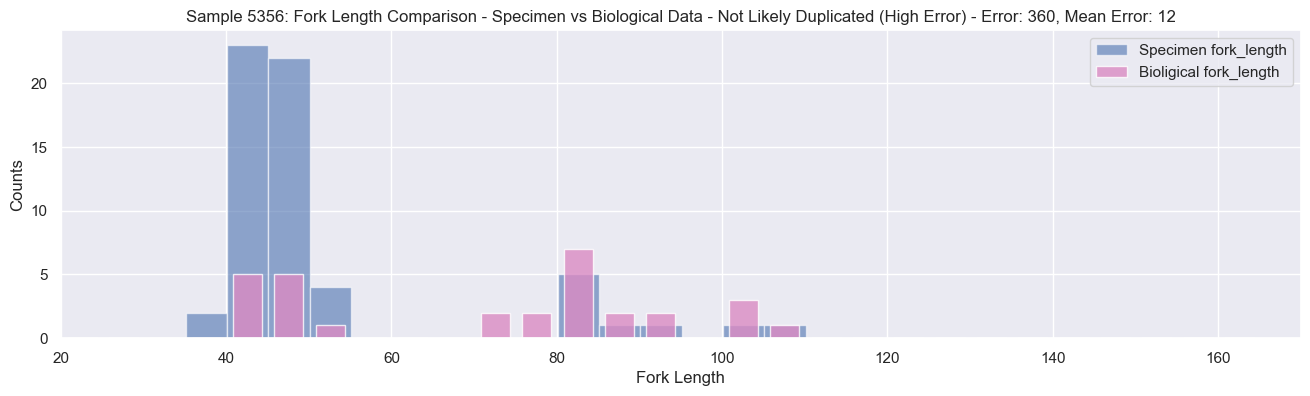

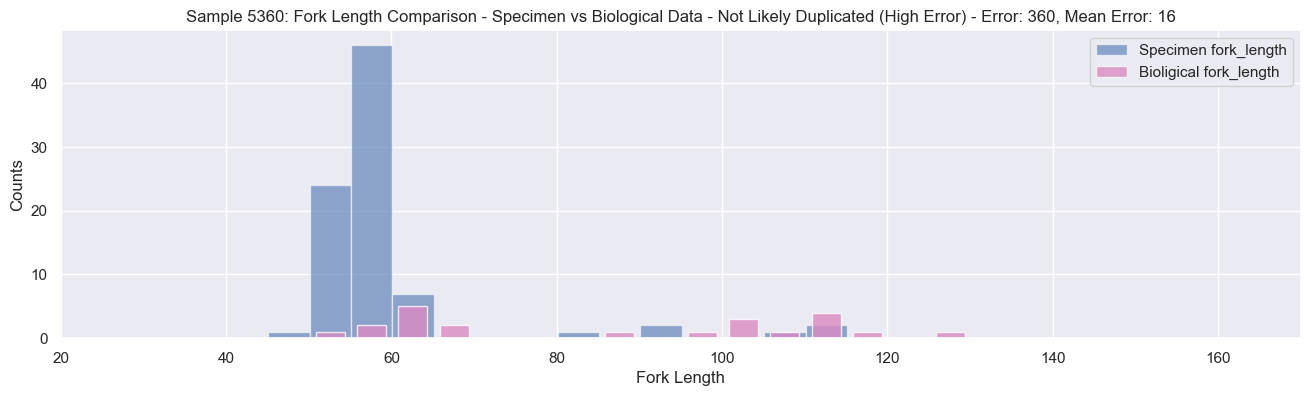

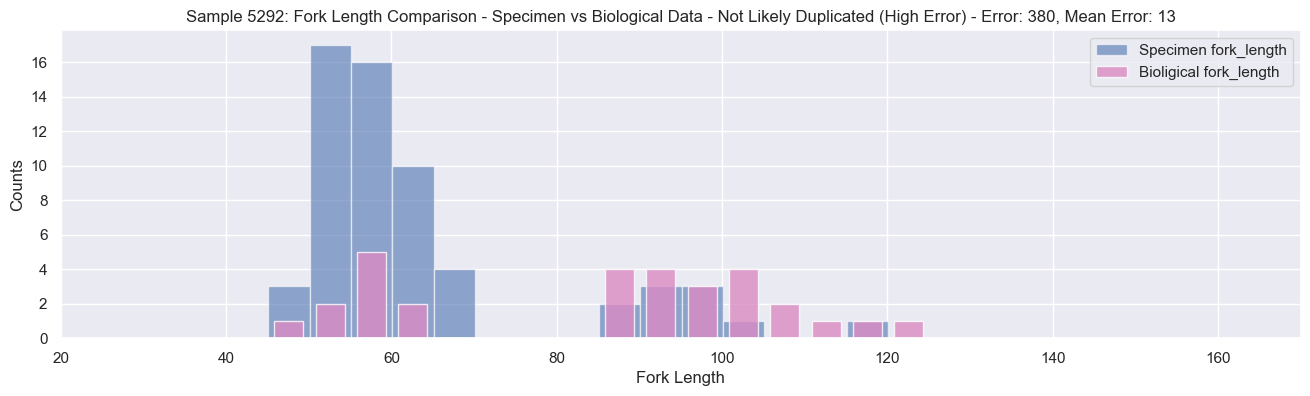

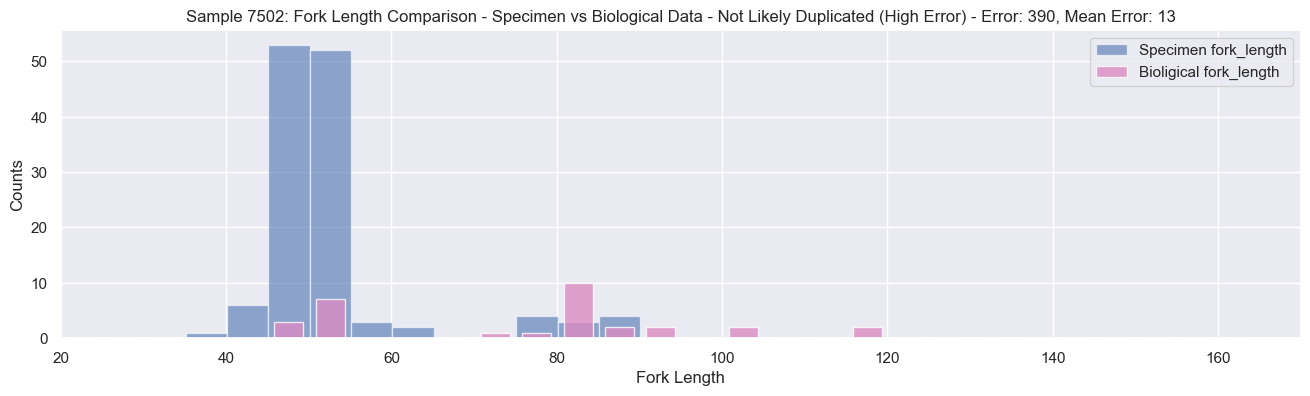

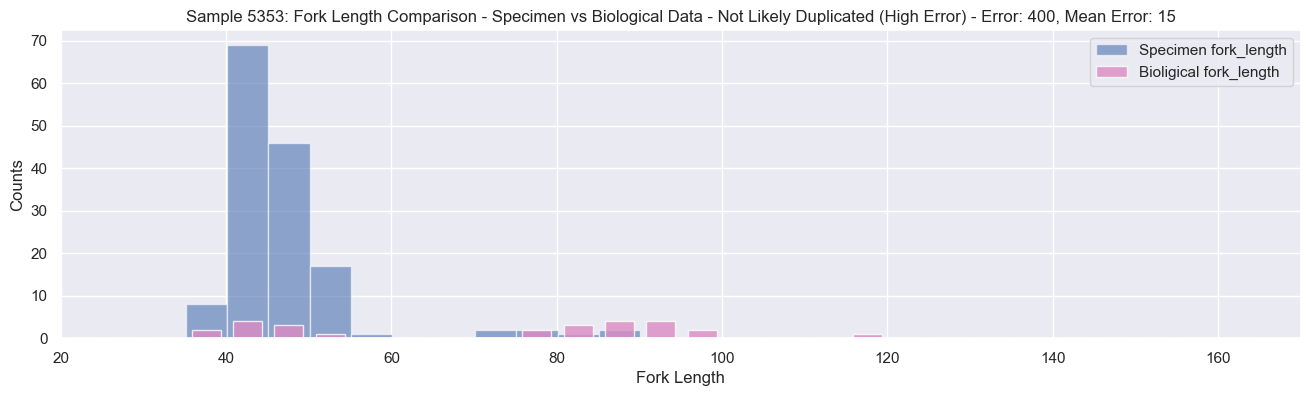

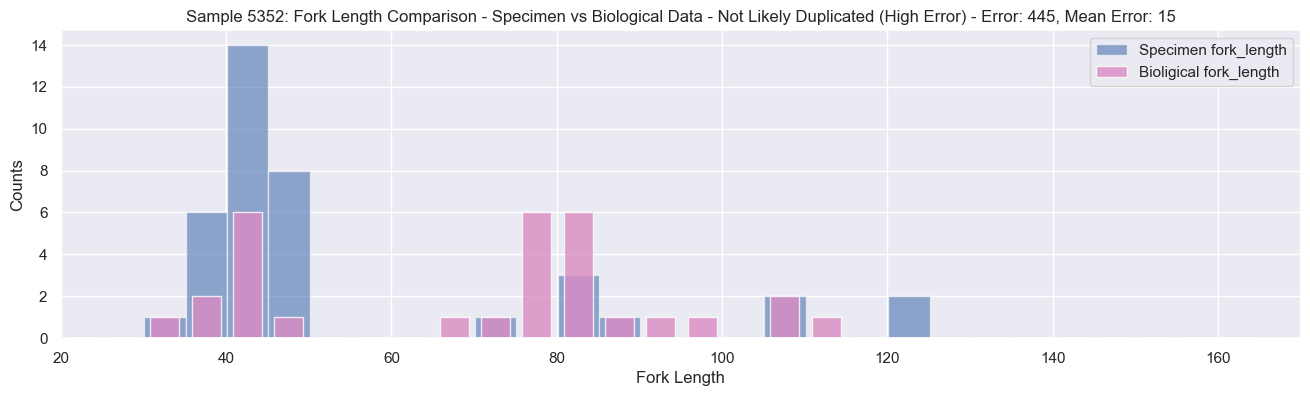

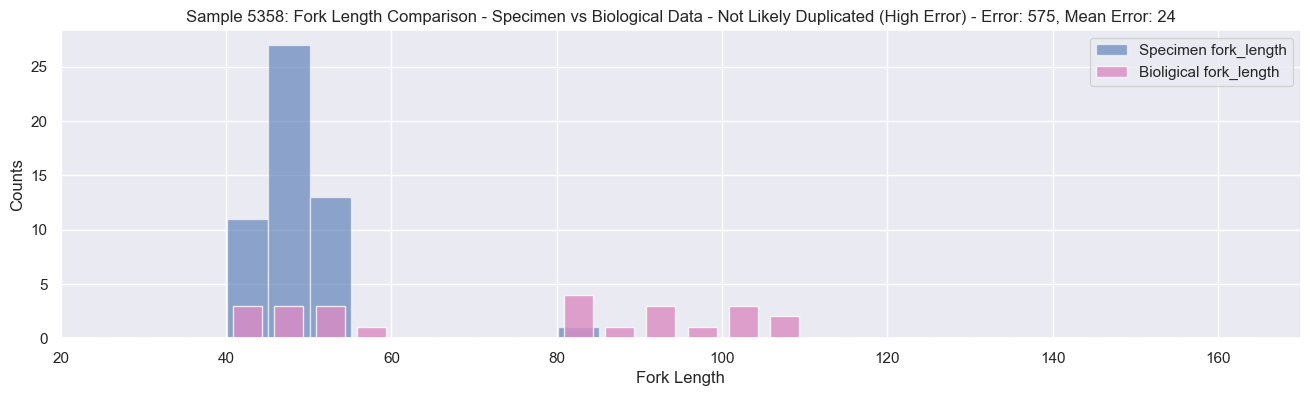

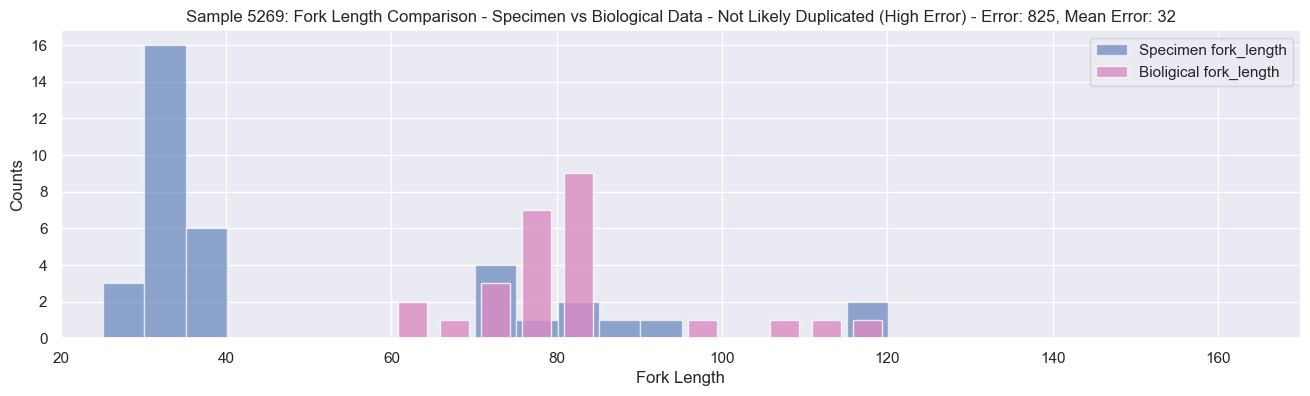

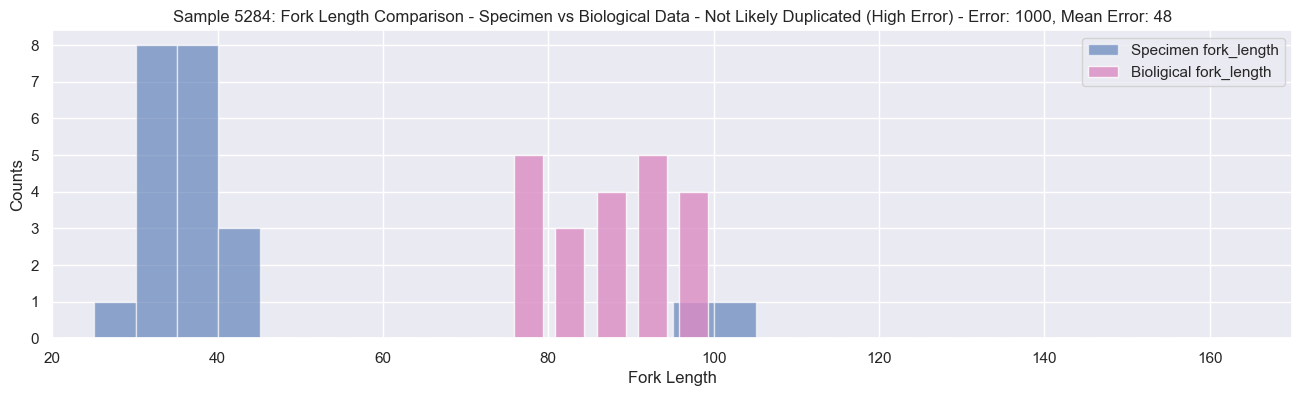

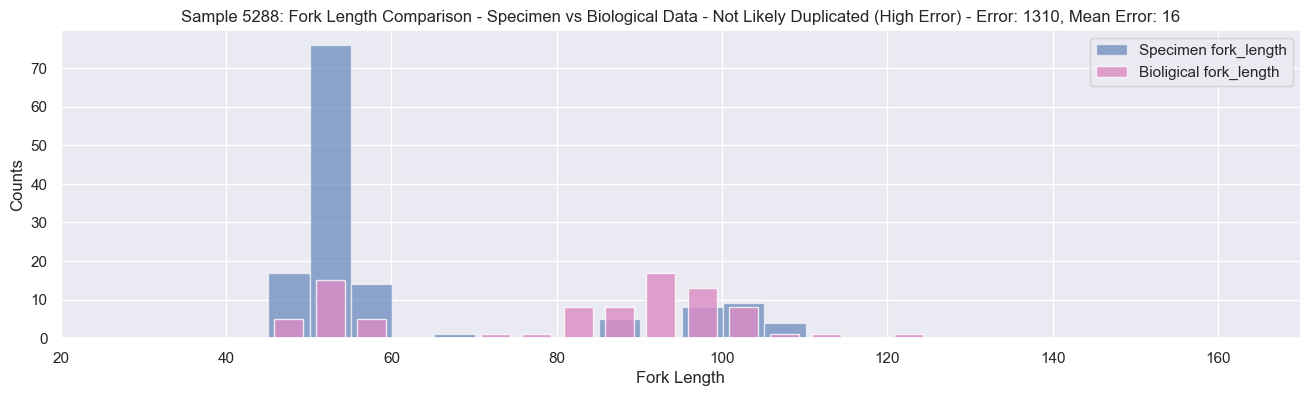

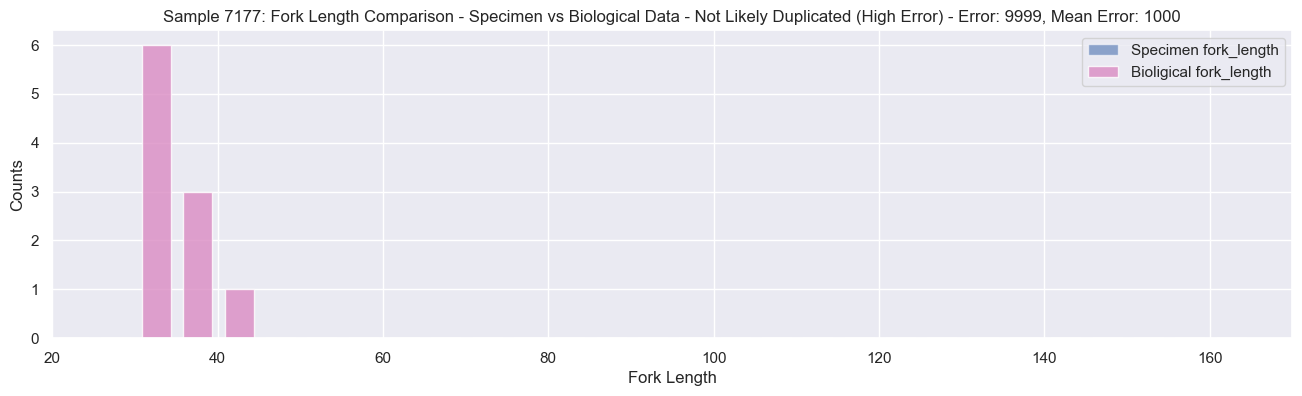

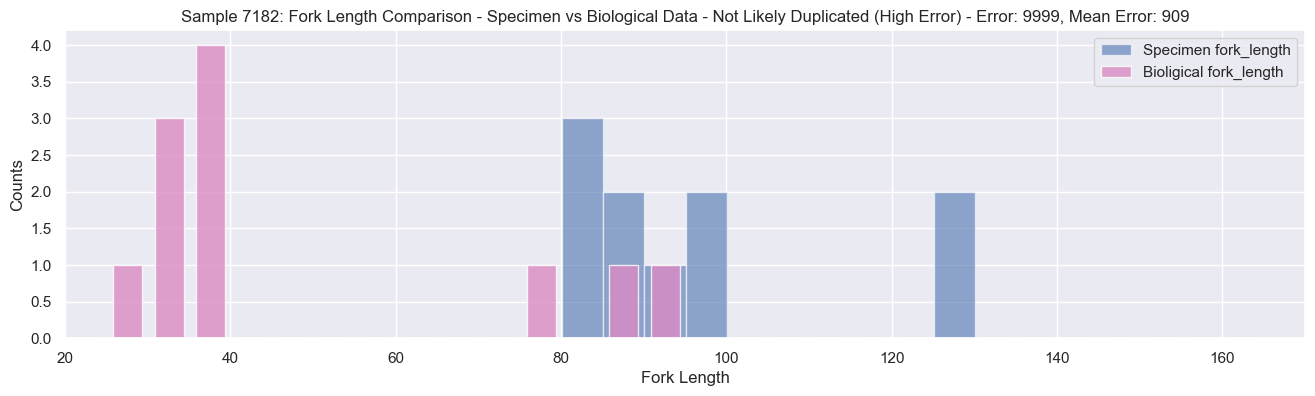

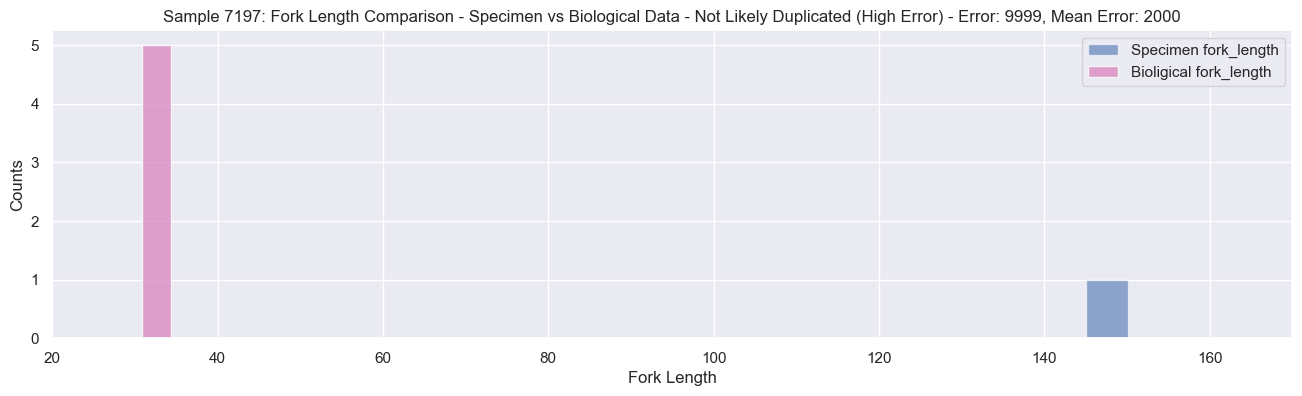

In [11]:
print(df_summary.high_error_potential_duplicate.notnull().sum(), 'High Error Samples')
for i in df_summary[df_summary.high_error_potential_duplicate.notnull()].sort_values('error', ascending=True).index:
    if i in potential_duplicates:
        print('\n\n\nPOTENTIAL DUPLICATE: Sample', i)
        plot_fork_length_by_sample(df_spec, df_hist, i, subtitle=f'Not Likely Duplicated (High Error) - Error: {round(df_summary.loc[i].error)}, Mean Error: {round(df_summary.loc[i].mean_error)}', duplicate=True)
    else:
        plot_fork_length_by_sample(df_spec, df_hist, i, subtitle=f'Not Likely Duplicated (High Error) - Error: {round(df_summary.loc[i].error)}, Mean Error: {round(df_summary.loc[i].mean_error)}', duplicate=False)

# matched counts spec vs bio - likely overlap/duplication - sorted by most error first

Notes:
* even high error samples have strongly correlated distributions
    * this appears to be systematic measurement error, and not coincidental overlap

### RECOMMENDATION: classify all of these samples as duplicated (matched_counts)

In [12]:
df_summary.loc[df_summary.index.isin(matched_counts), 'matched_counts'] = True
print(df_summary[df_summary.matched_counts==True].shape[0], 'Matching Number of Specimen and Bio Samples')

179 Matching Number of Specimen and Bio Samples


POTENTIAL EXCEPTION: High Error / Inconsistent Distributions


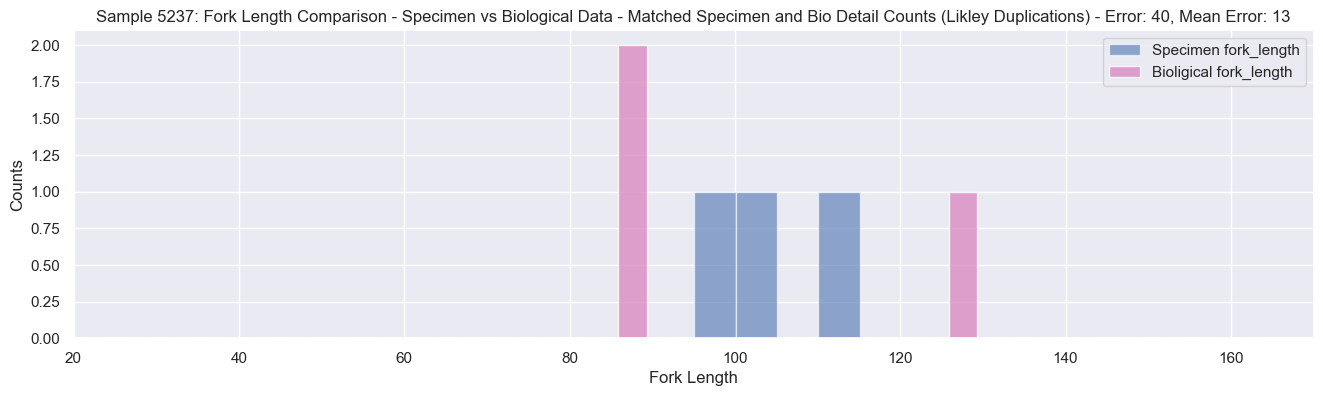

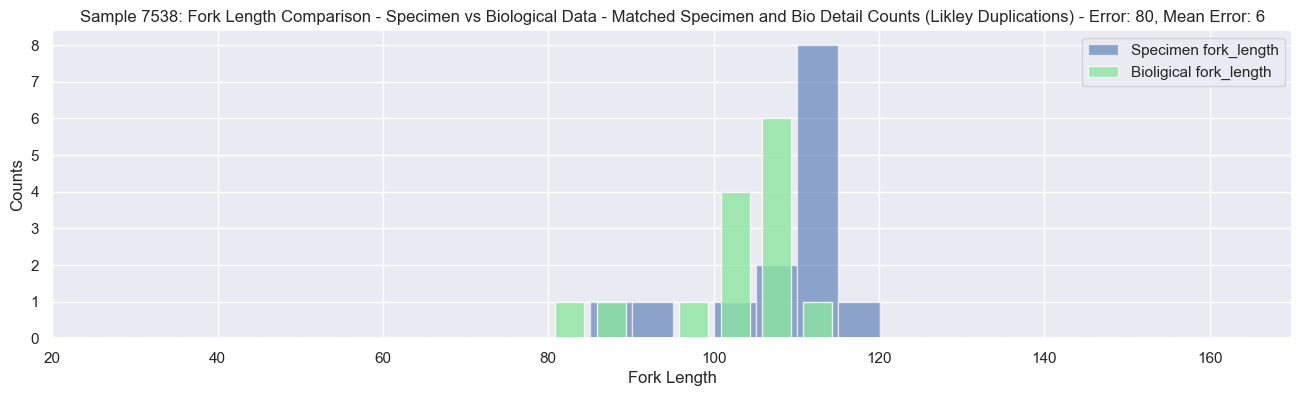

POTENTIAL EXCEPTION: High Error / Inconsistent Distributions


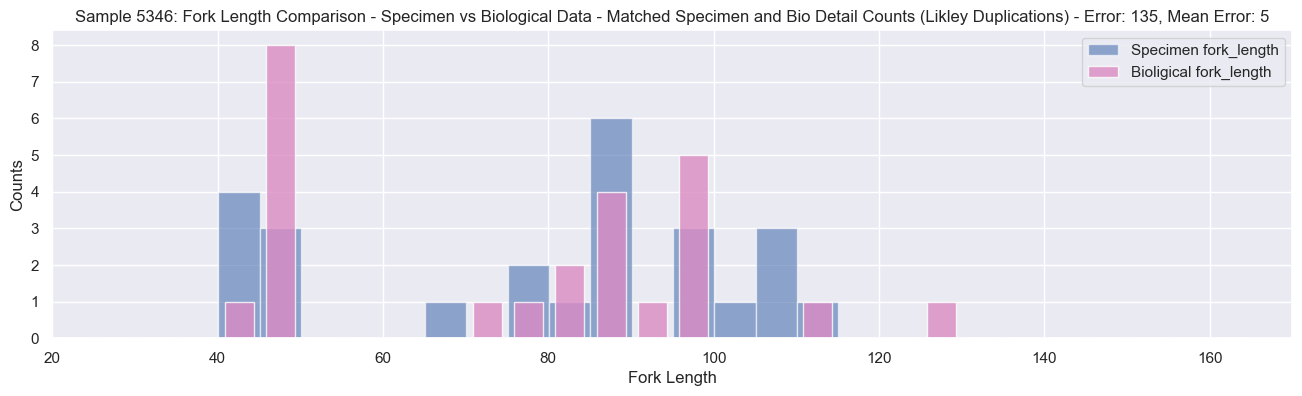

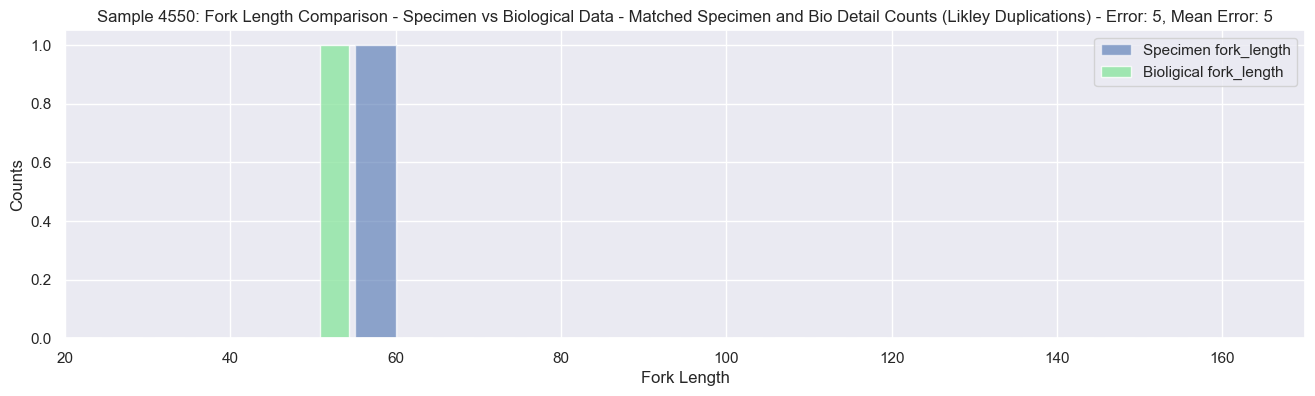

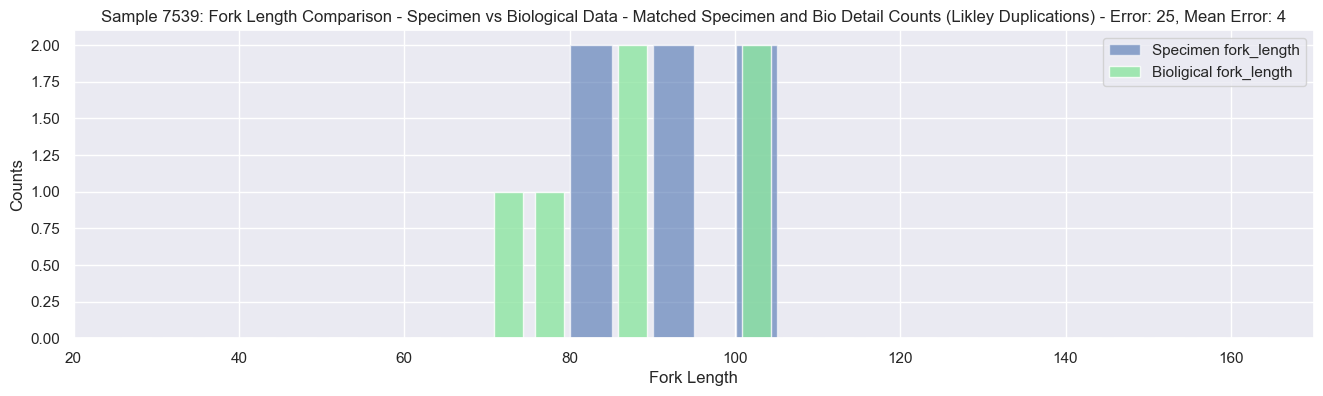

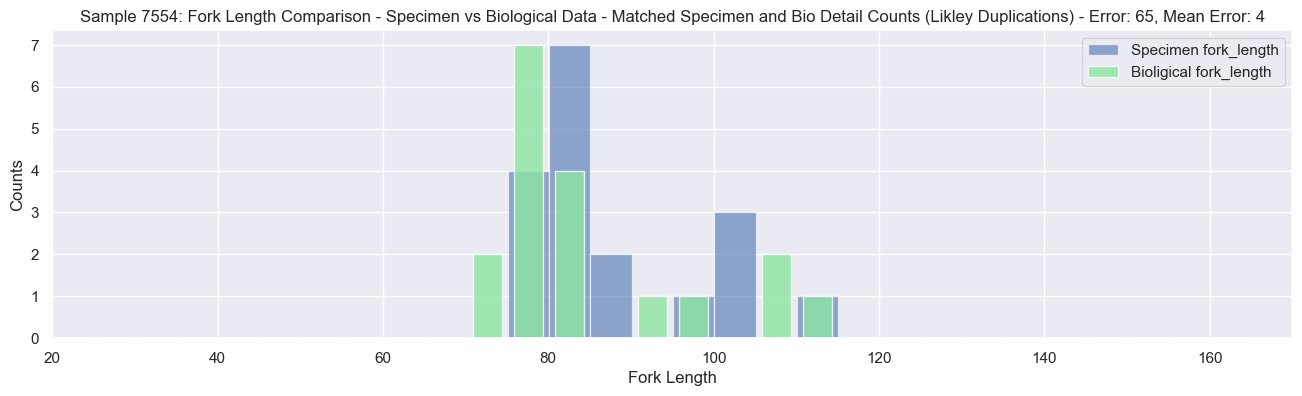

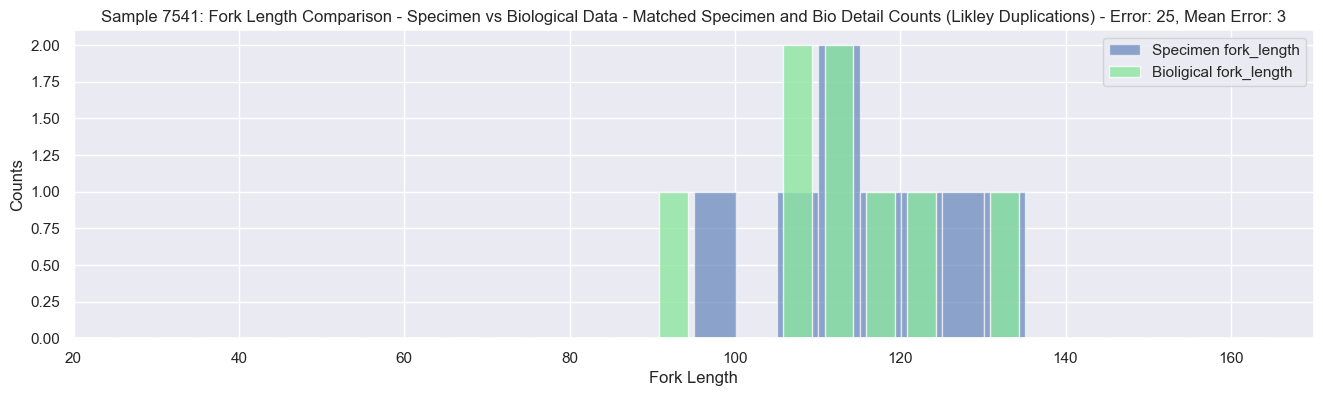

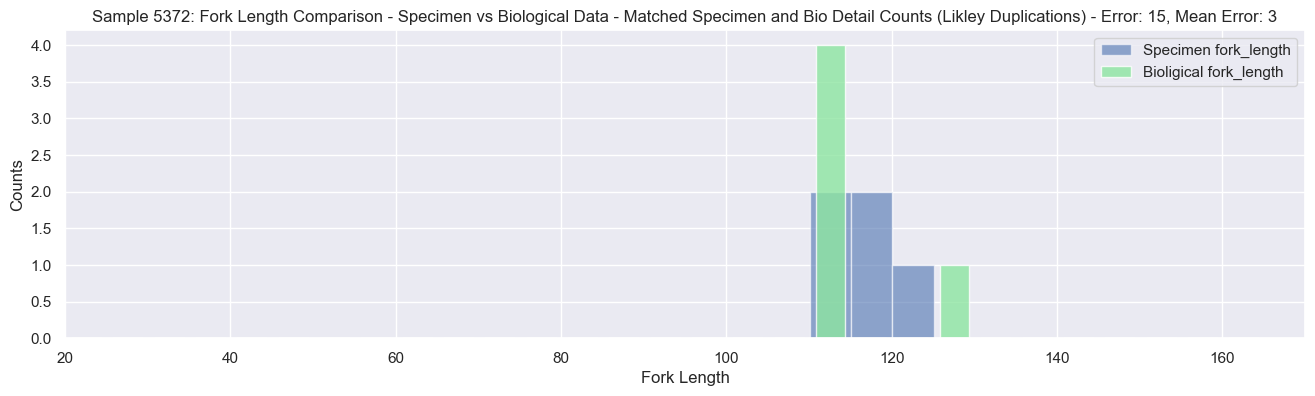

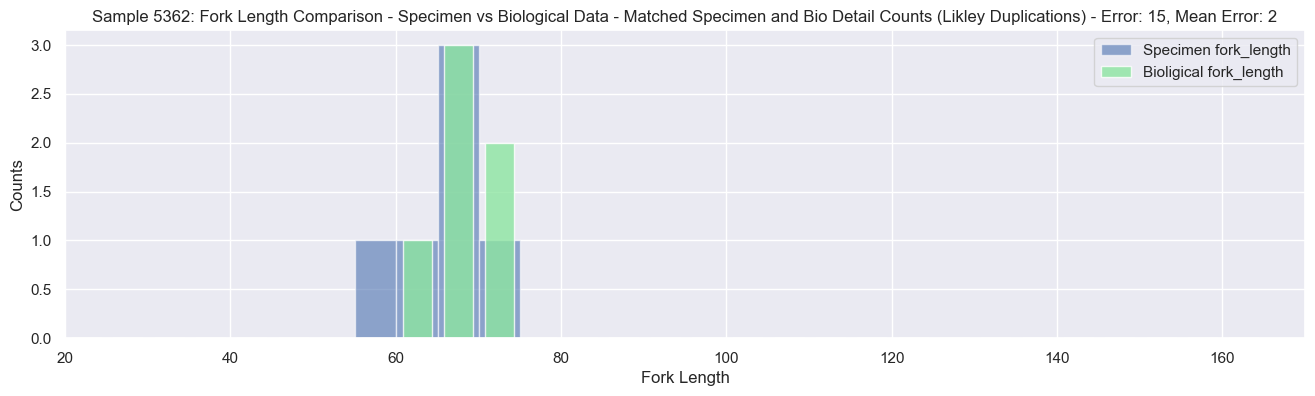

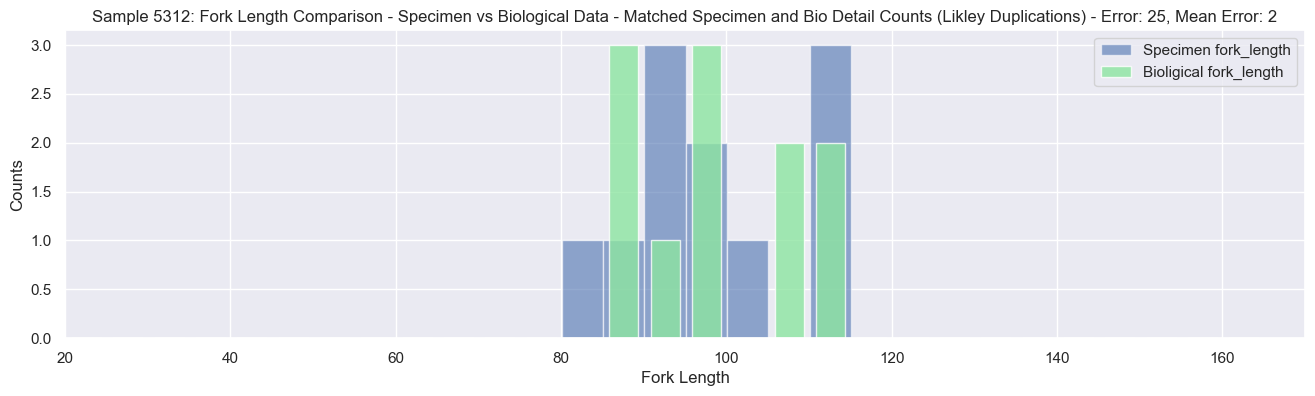

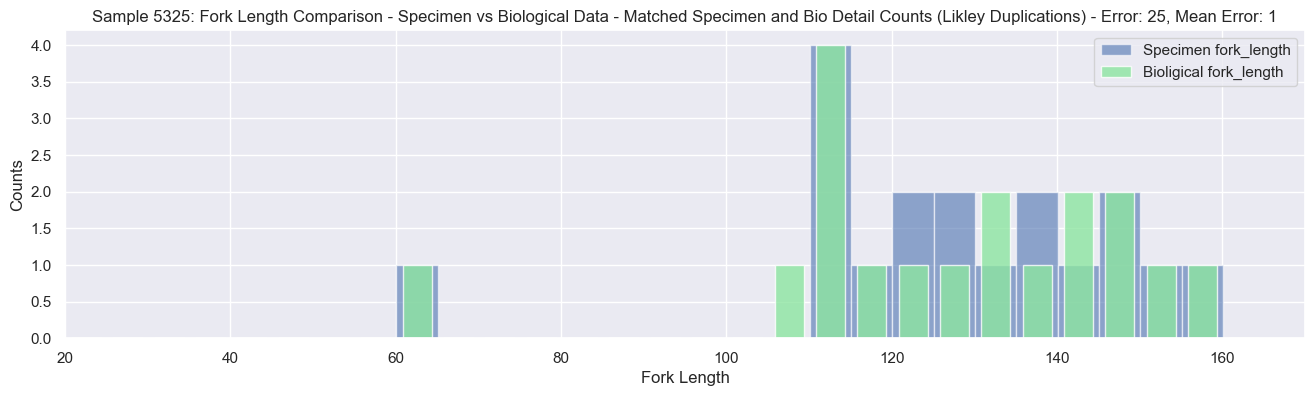

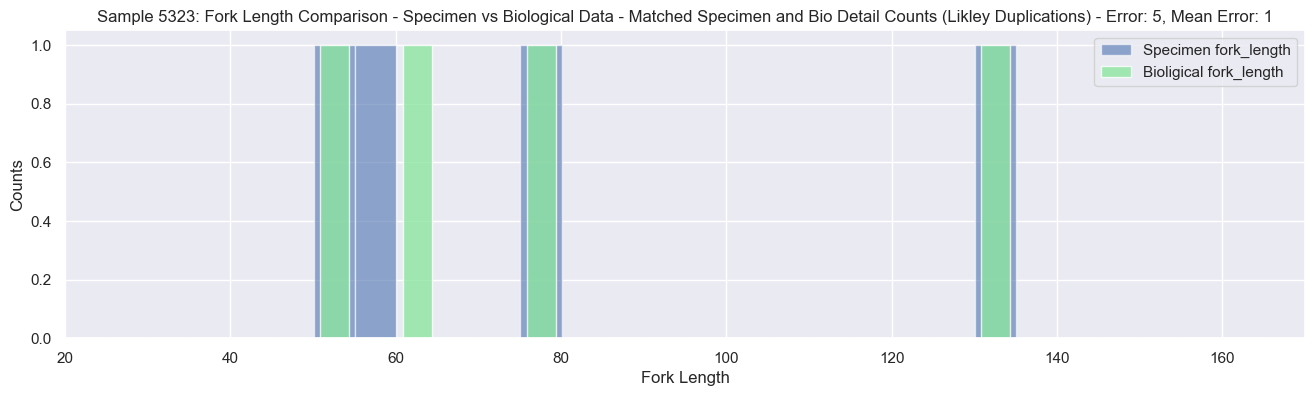

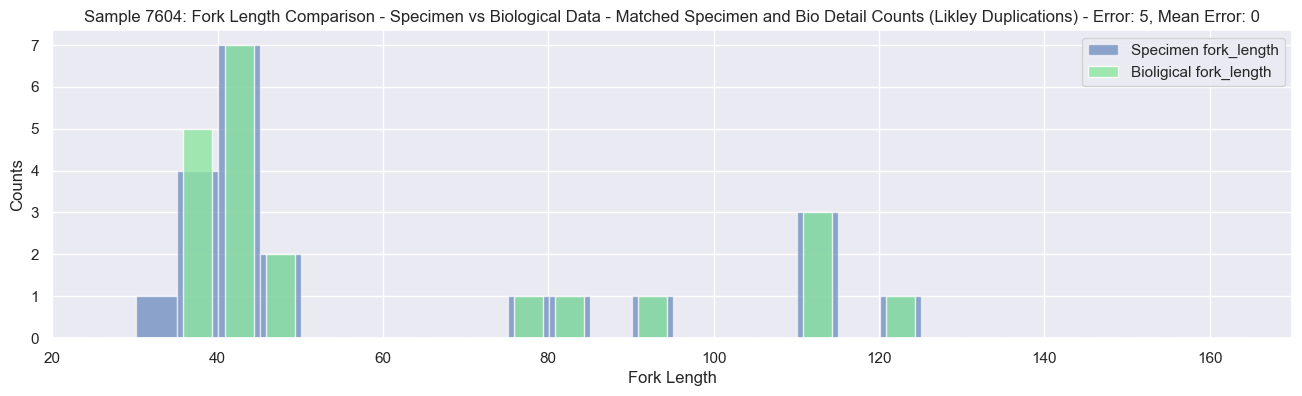

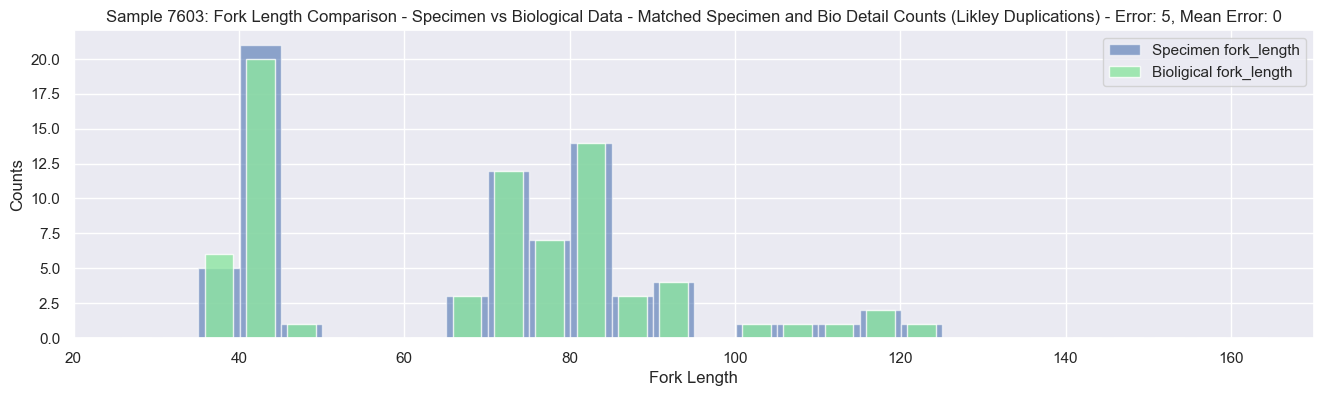

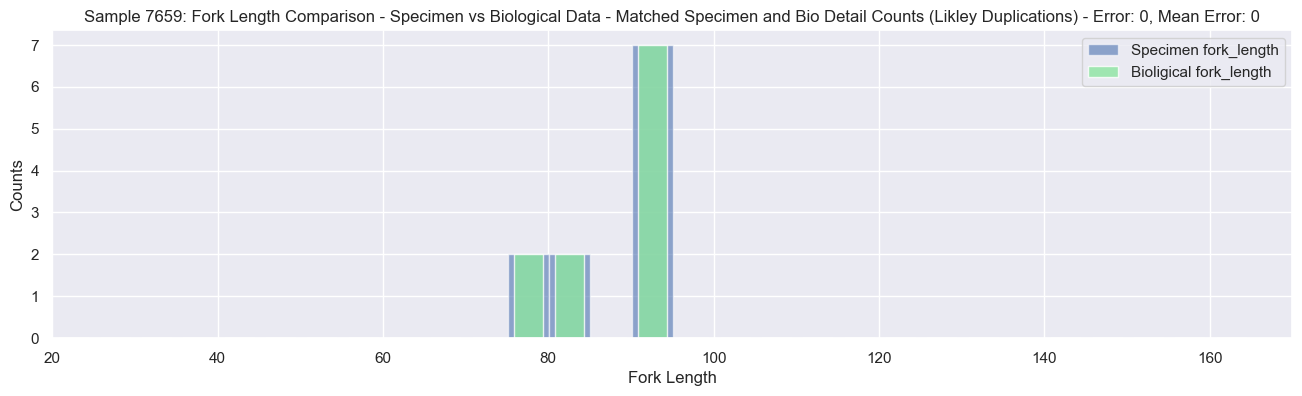

In [13]:
# plot until error -> 0
potential_exceptions = [5237, 5346]
for i in df_summary[df_summary.matched_counts==True].sort_values('mean_error', ascending=False).head(15).index:
    if i in potential_exceptions:
        print('POTENTIAL EXCEPTION: High Error / Inconsistent Distributions')
        plot_fork_length_by_sample(df_spec, df_hist, i, subtitle=f'Matched Specimen and Bio Detail Counts (Likley Duplications) - Error: {round(df_summary.loc[i].error)}, Mean Error: {round(df_summary.loc[i].mean_error)}', duplicate=False)
    else:
        plot_fork_length_by_sample(df_spec, df_hist, i, subtitle=f'Matched Specimen and Bio Detail Counts (Likley Duplications) - Error: {round(df_summary.loc[i].error)}, Mean Error: {round(df_summary.loc[i].mean_error)}', duplicate=True)

# count probable, definite, and unlikely matches - focus remaining analysis on remaining samples

In [14]:
all_flags = ['specimen_data', 'enough_spec_data', 'zero_error_sample', 'high_error_potential_duplicate', 'matched_counts']
for i in all_flags:
    print(df_summary[i].notnull().sum(), i)

18 specimen_data
8 enough_spec_data
534 zero_error_sample
30 high_error_potential_duplicate
179 matched_counts


In [15]:
# flagged recommendations vs total entries
df_summary[(df_summary[all_flags].notnull()).any(axis=1)].shape[0], df_summary.shape[0]

(604, 793)

In [16]:
# check samples with multiple flags for consistency
df_summary[(df_summary[all_flags].notnull()).any(axis=1)][all_flags][
    (df_summary[(df_summary[all_flags].notnull()).any(axis=1)][all_flags].count(axis=1) > 1)
].fillna('').describe()

,specimen_data,enough_spec_data,zero_error_sample,high_error_potential_duplicate,matched_counts
count,165,165,165,165,165
unique,1,1,1,1,1
top,,,True,,True
freq,165,165,165,165,165


189 Samples Unflagged


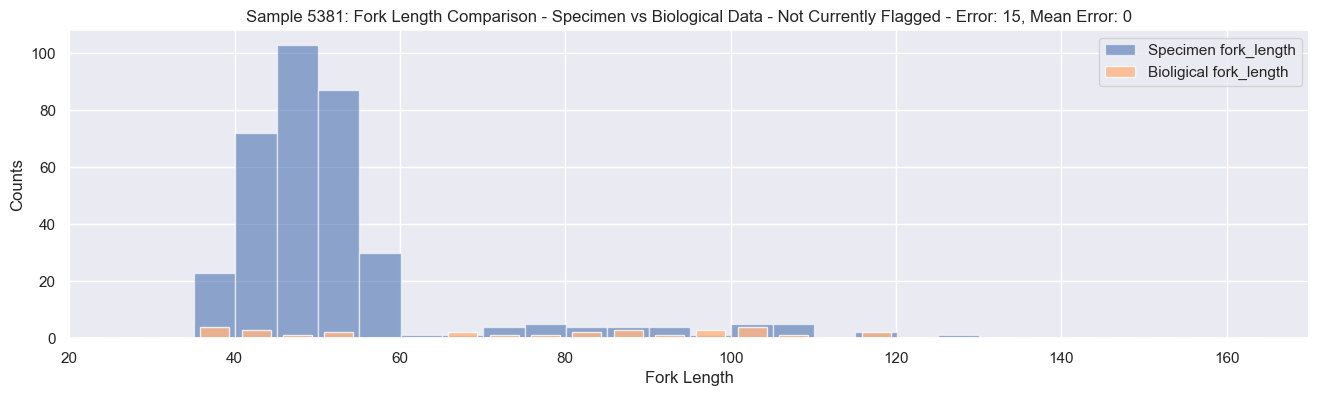

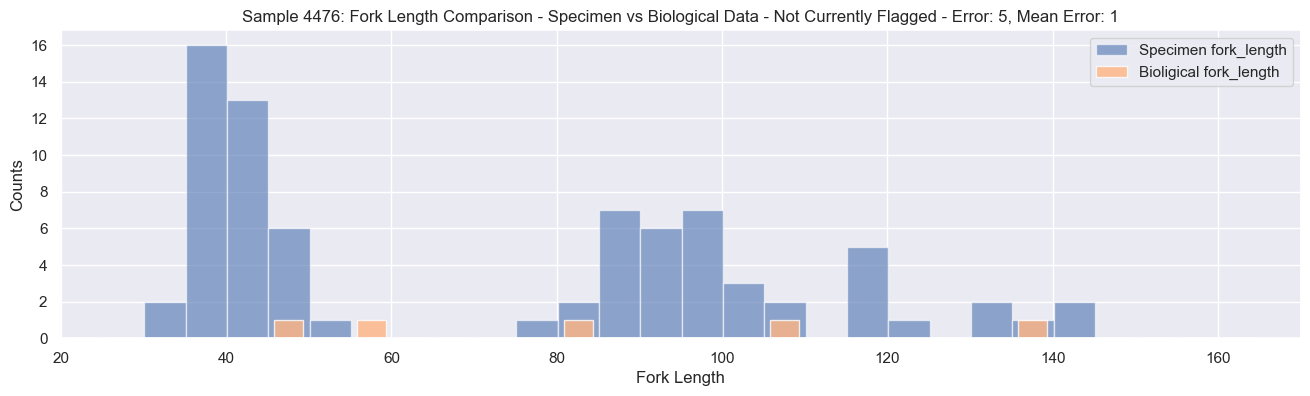

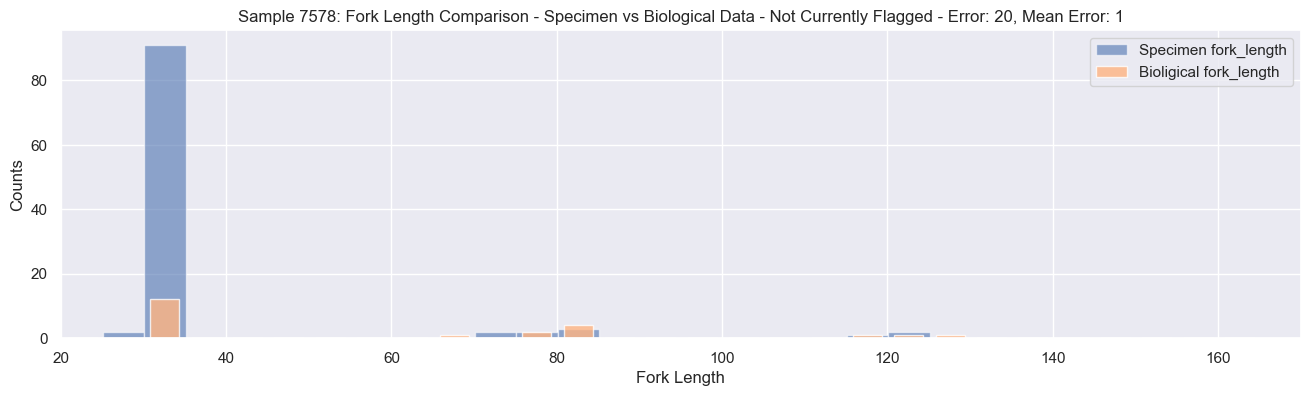

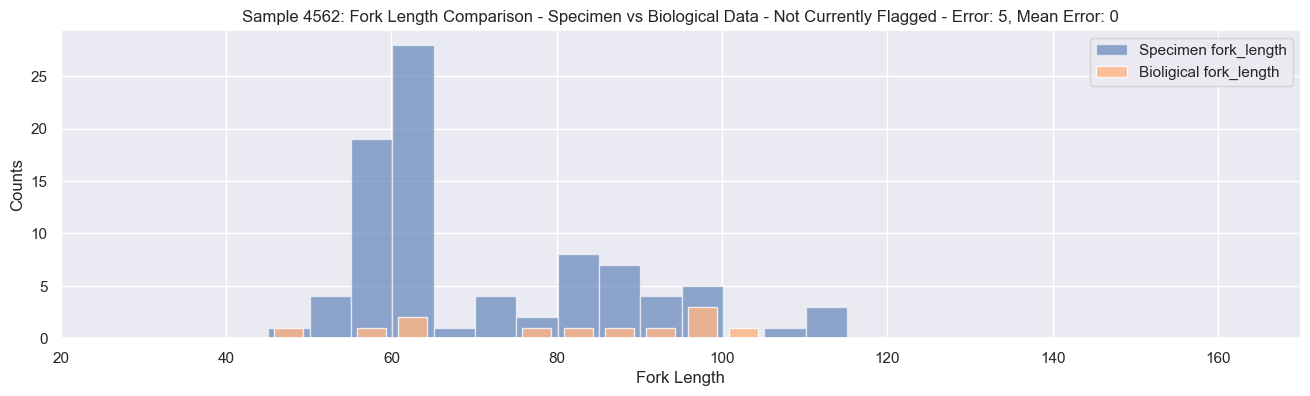

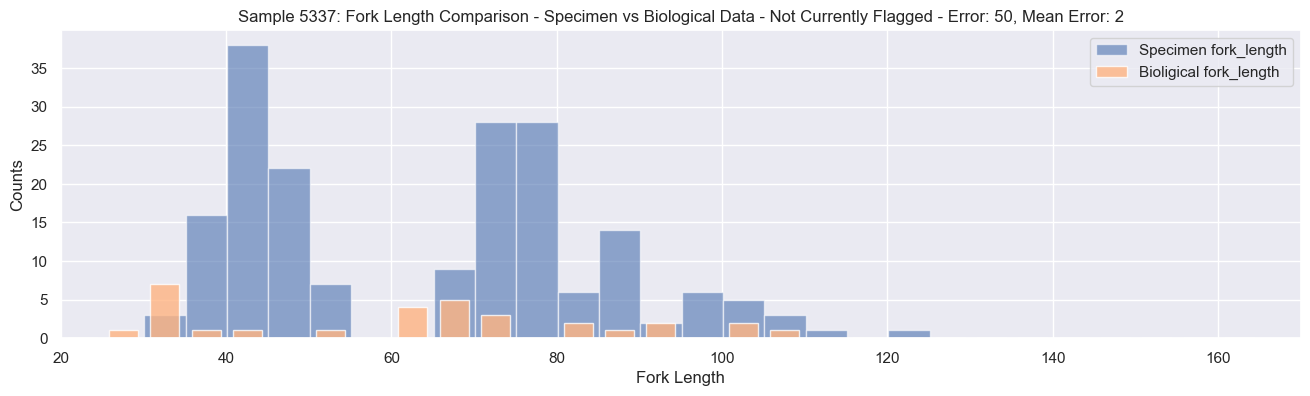

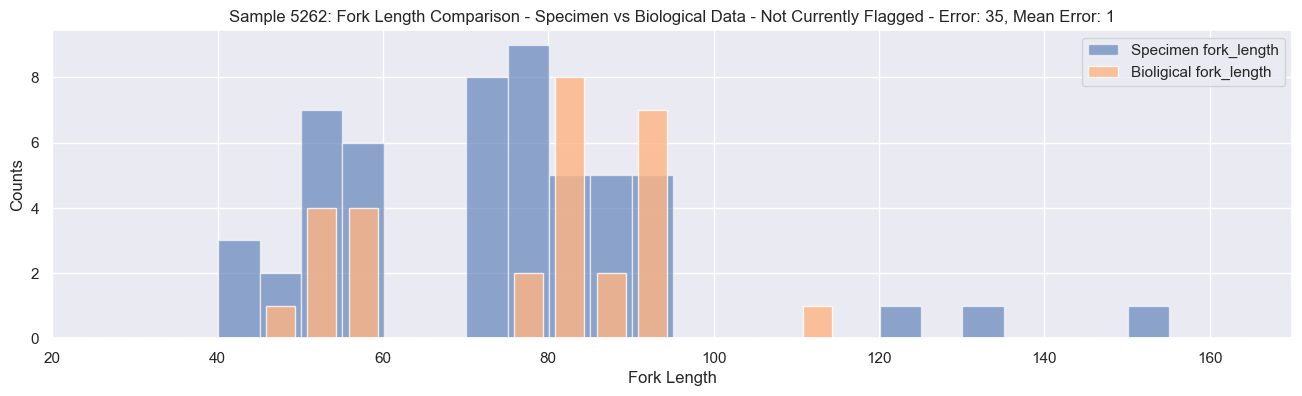

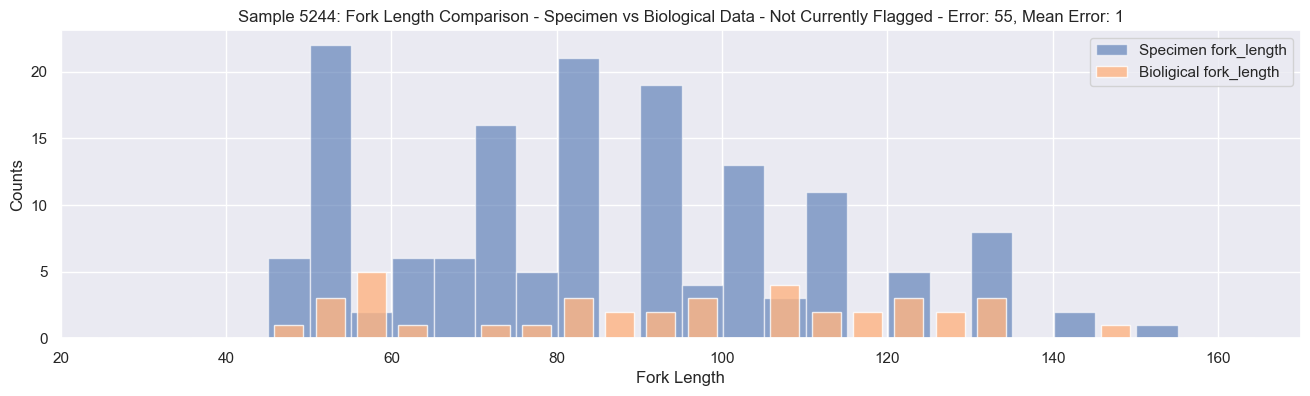

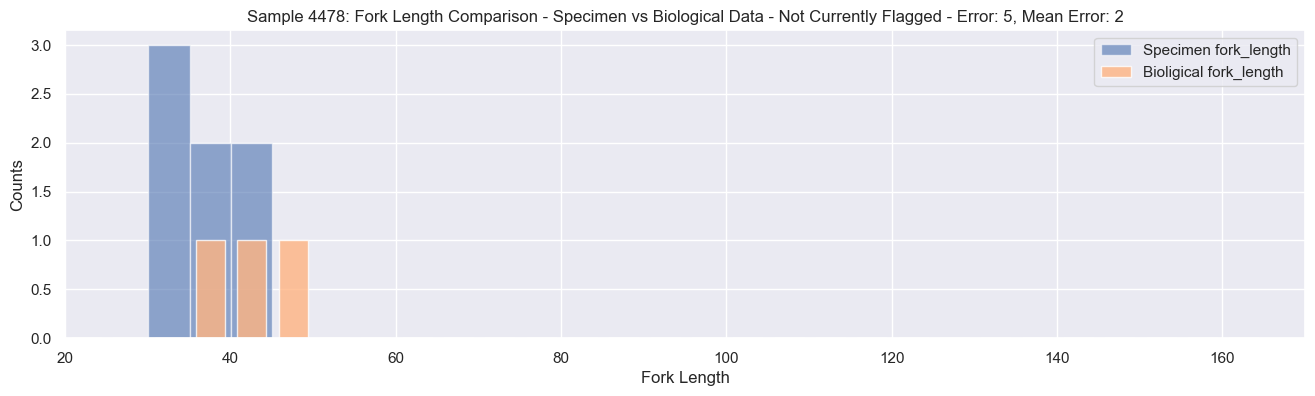

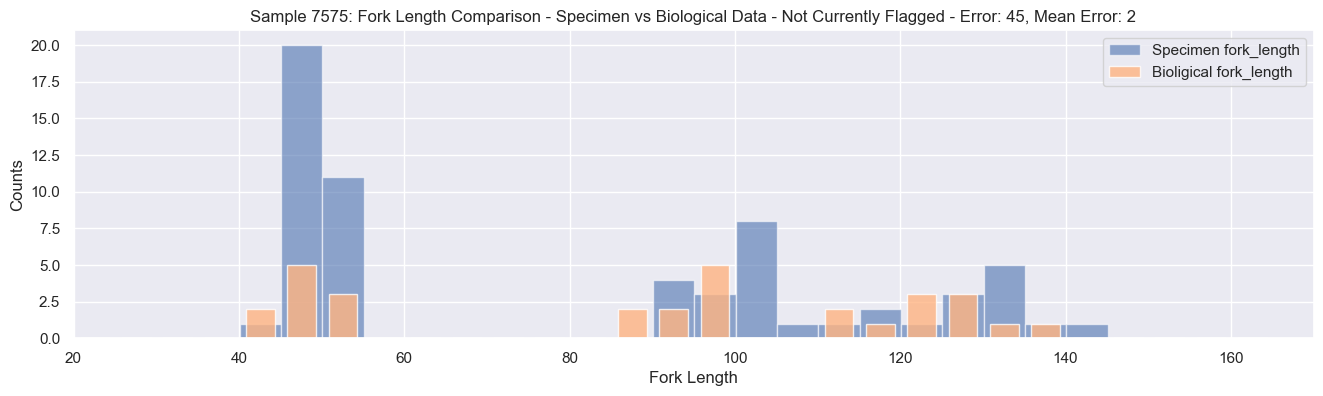

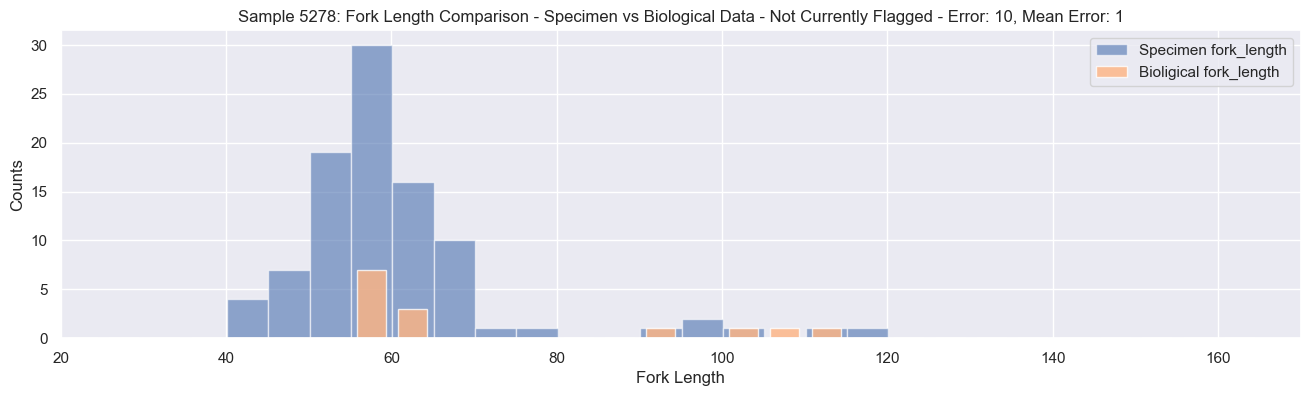

In [17]:
# Let's take a look at the remainder to see if there's anything obvious
# just plot a sample

print(df_summary[(df_summary[all_flags].isnull()).all(axis=1)].shape[0], 'Samples Unflagged')
for i in df_summary[(df_summary[all_flags].isnull()).all(axis=1)].sample(10).index:
    plot_fork_length_by_sample(df_spec, df_hist, i, subtitle=f'Not Currently Flagged - Error: {round(df_summary.loc[i].error)}, Mean Error: {round(df_summary.loc[i].mean_error)}')

# Save Summary File - rename to df_recommendations

In [18]:
if False:
    df_summary.to_pickle('calculations\df_recommendations.pickle')

# Statistical Analysis: estimated proportion of matches
* how many perfect matches should we expect due to randomness? 
    * we would expect less than 3% matches with random sets of biological samples and specimen data
    * we have 67% matches
        * this indicates that most of these samples are very likley to be double counted

In [19]:
# 534 perfect matches with new bins, vs 203 with the old bins
df_summary.zero_error_sample.count(), 203, df_summary.shape[0]

(534, 203, 793)

In [20]:
# what about a random subset?
# IQR 9 - 43
df_hist.groupby('sample_id').count().fork_length.describe()

count   793.000
mean     34.681
std      39.670
min       1.000
25%       9.000
50%      25.000
75%      43.000
max     346.000
Name: fork_length, dtype: float64

In [21]:
def simulate_random_matches_v2(debug=False):
    bins = [x for x in range(20, 170, 5)]
    
    # both dataset are based off the same distribution to avoid sampling error, and make a conservative estimate
    df1 = df_spec[df_spec.sample_id == df_spec.sample().sample_id.values[0]].copy()
    df2 = df_spec.sample(np.random.randint(9, 43)).copy()

    bin1 = df1.groupby(pd.cut(df1.fork_length, bins)).fork_length.count().to_list()
    bin2 = df2.groupby(pd.cut(df2.fork_length, bins)).fork_length.count().to_list()
    
    if debug:
        print(bin1)
        print(bin2)

    for b1, b2 in zip(bin1, bin2):
        if b1 < b2:
            return 0
    return 1

In [22]:
%%time

matches, trials = 0, 10000
for _ in range(trials):
    matches += simulate_random_matches_v2()

matches / trials

Wall time: 1min 38s


0.0261

# what about the potentially incorrect imports?
* analysis updated in another workbook